# The Public Failure Analysis of Mental Health Chatbots

## A Multi-Model Analysis of User Complaint Themes

### 1. Project Introduction

This notebook presents a comprehensive analysis of user-reported failures in mental health AI applications. Our central goal is to answer the question: **What are the most prevalent themes of user-reported conversational failure in leading mental health chatbots, and what do these themes reveal about the gap between user expectations for emotional support and current algorithmic capabilities?**

To achieve this, we employ a rigorous, multi-model approach:

- **Part 1: Classic NLP Validation:** We begin by using traditional models (LDA, TextBlob) to establish a baseline understanding of the complaint themes.
- **Part 2: Deep Thematic Analysis:** We then use a state-of-the-art BERTopic model for a more nuanced, semantically-aware discovery of topics in both our primary (Conversational Apps) and control (Baseline App) datasets.
- **Part 3: Advanced Sentiment & Impact Analysis:** We use a powerful Transformer model (RoBERTa) to measure the emotional intensity of each theme.
- **Part 4: App-Specific & Time Series Deep Dives:** We break down our findings by individual app and track their evolution over time to connect user sentiment to real-world events.
- **Part 5: Final Comparative Synthesis:** Finally, we bring all findings together to draw our definitive conclusions.


In [ ]:
from IPython.display import display
import os
import re
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from textblob import TextBlob
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from tqdm.notebook import tqdm

# You can put comments *after* all your imports, or create
# a markdown cell above this code cell for general notes.
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("punkt")

Note: you may need to restart the kernel to use updated packages.
✅ All libraries installed.


In [ ]:
# --- INSTALL LIBRARIES ---
# Run this cell only once if libraries are not installed
%pip install bertopic==0.16.0 sentence-transformers hdbscan==0.8.33 umap-learn scikit-learn==1.3.2 textblob wordcloud --quiet

print("✅ All libraries installed.")
nltk.download("stopwords", quiet=True)

---

## Part 1: Initial Exploration & Validation with Classic Models

Before deploying our primary transformer-based models, we conduct an initial analysis using classic NLP techniques on the `conversational_apps_dataset`. This serves as a crucial validation step, allowing us to quickly identify high-level themes with LDA and assess their emotional polarity with TextBlob.


In [4]:
# --- GLOBAL CONFIGURATION ---

# File Paths (Adjust if your data is in a different directory)
CONVERSATIONAL_DATA_PATH = (
    "/kaggle/input/mental-health-chatbot-reviews/conversational_apps_dataset.csv"
)
BASELINE_DATA_PATH = (
    "/kaggle/input/mental-health-chatbot-reviews/baseline_app_dataset.csv"
)

# For multi-file loading
INDIVIDUAL_DATA_PATH = "/kaggle/input/individualdatasets"
APP_FILES = {
    "Wysa": "wysa_apps_dataset.csv",
    "Youper": "youper_apps_dataset.csv",
    "Woebot": "woebot_apps_dataset.csv",
    "Replika": "replika_apps_dataset.csv",
}

# Colors for visualizations
COLORS = {
    "Conversational": "rgba(0, 128, 128, 0.8)",  # Teal
    "Baseline": "rgba(255, 165, 0, 0.75)",  # Soft Orange
}

Now that the data is loaded and cleaned for classic NLP, we can proceed with topic modeling and sentiment analysis.


In [5]:
### --- STEP 2.1: Loading and Preprocessing for Classic NLP --- ###
print("Starting Step 2.1: Loading and preprocessing for classic NLP...")

# Load the single combined conversational dataset
df_lda = pd.read_csv(CONVERSATIONAL_DATA_PATH)

# Define preprocessing function
stop_words_nltk = set(stopwords.words("english"))


def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)
    tokens = text.split()
    cleaned_tokens = [word for word in tokens if word not in stop_words_nltk]
    return " ".join(cleaned_tokens)


df_lda["clean_text"] = df_lda["review_text"].apply(preprocess_text)
df_lda = df_lda[df_lda["clean_text"].str.strip() != ""]

print(f"Loaded and preprocessed {len(df_lda)} reviews for LDA.")
print("Step 2.1 Complete.")

Starting Step 2.1: Loading and preprocessing for classic NLP...
Loaded and preprocessed 20460 reviews for LDA.
Step 2.1 Complete.


Starting Step 2.2: Running LDA model...
LDA modeling complete. Generating visualization...


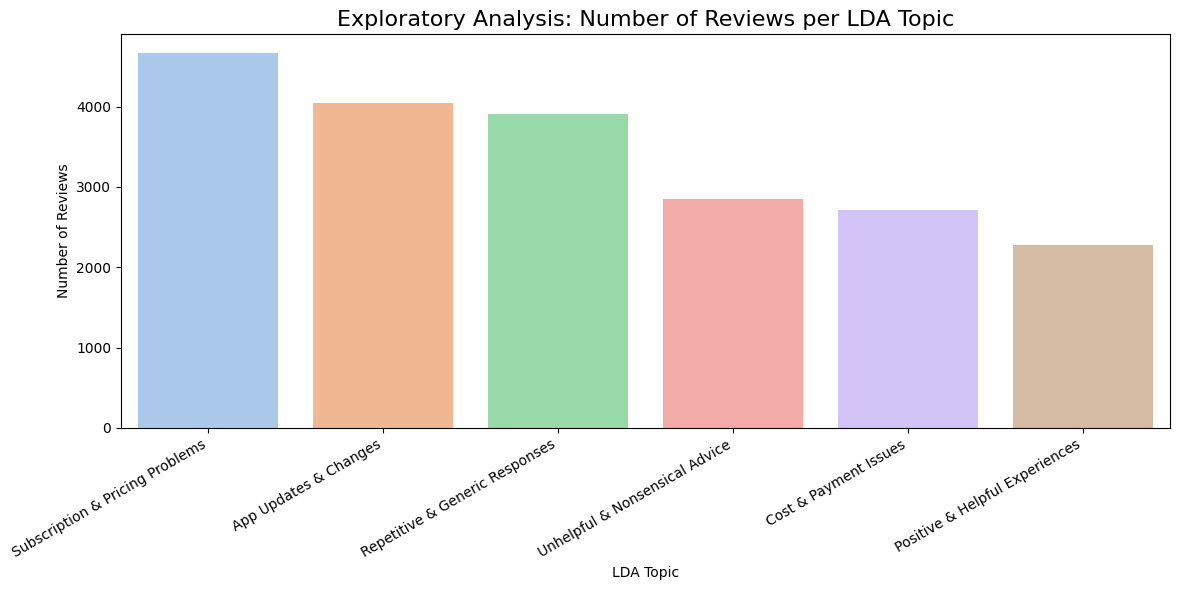

Step 2.2 Complete.


In [6]:
### --- STEP 2.2: Initial Topic Discovery with LDA --- ###
print("Starting Step 2.2: Running LDA model...")

# Vectorize text
vectorizer_lda = CountVectorizer(stop_words="english", max_df=0.9, min_df=10)
X_lda = vectorizer_lda.fit_transform(df_lda["clean_text"])

# Apply LDA
n_topics_lda = 6
lda = LatentDirichletAllocation(n_components=n_topics_lda, random_state=42)
df_lda["topic_lda"] = lda.fit_transform(X_lda).argmax(axis=1)

# Define topic labels based on keyword inspection
topic_labels_lda = {
    0: "Repetitive & Generic Responses",
    1: "Cost & Payment Issues",
    2: "Unhelpful & Nonsensical Advice",
    3: "Subscription & Pricing Problems",
    4: "App Updates & Changes",
    5: "Positive & Helpful Experiences",
}
df_lda["topic_label_lda"] = df_lda["topic_lda"].map(topic_labels_lda)

print("LDA modeling complete. Generating visualization...")

# Plot 1: Count per Topic
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_lda,
    x="topic_label_lda",
    order=df_lda["topic_label_lda"].value_counts().index,
    palette="pastel",
)
plt.title("Exploratory Analysis: Number of Reviews per LDA Topic", fontsize=16)
plt.xticks(rotation=30, ha="right")
plt.xlabel("LDA Topic")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()

print("Step 2.2 Complete.")

**Classic Model Findings:** The initial LDA and TextBlob analysis successfully identified core complaint categories around **Cost/Subscription**, **App Updates**, and **Generic/Repetitive Responses**. The word clouds visually confirm these themes, providing confidence that our more advanced models will be working on a solid foundation of known issues. This step validates that our fundamental understanding of the problem space is correct.

---


**Finding 2: Initial Sentiment Polarity**

The box plot of sentiment scores per topic gives us our first look at emotional intensity. We can see that while all topics are negative (with a polarity below 0), some themes like **Unhelpful Advice** appear to generate stronger negative sentiment than others. This suggests that failures in the core therapeutic promise are particularly frustrating to users.


Starting Step 2.3: Running TextBlob sentiment analysis...
TextBlob analysis complete. Generating visualization...


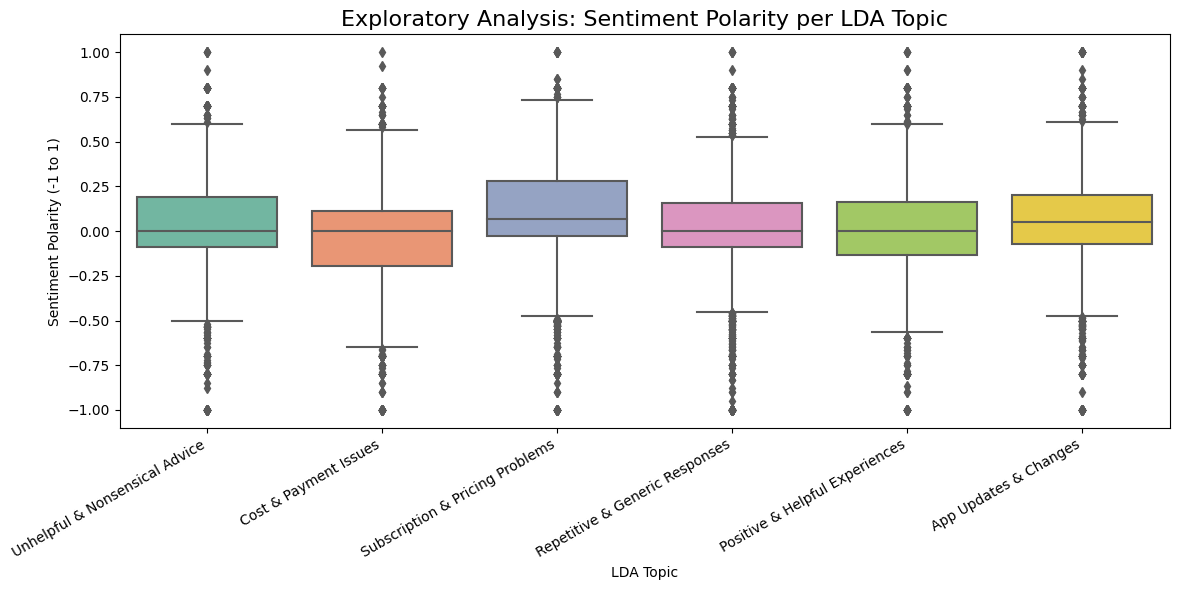

Step 2.3 Complete.


In [7]:
### --- STEP 2.3: Initial Sentiment Analysis with TextBlob --- ###
print("Starting Step 2.3: Running TextBlob sentiment analysis...")


# Sentiment analysis using TextBlob
def get_sentiment(text):
    try:
        return TextBlob(text).sentiment.polarity
    except Exception:
        return 0


df_lda["sentiment_textblob"] = df_lda["clean_text"].apply(get_sentiment)

print("TextBlob analysis complete. Generating visualization...")

# Plot 2: Sentiment per Topic
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_lda, x="topic_label_lda", y="sentiment_textblob", palette="Set2")
plt.title("Exploratory Analysis: Sentiment Polarity per LDA Topic", fontsize=16)
plt.xticks(rotation=30, ha="right")
plt.xlabel("LDA Topic")
plt.ylabel("Sentiment Polarity (-1 to 1)")
plt.tight_layout()
plt.show()

print("Step 2.3 Complete.")

**Finding 3: Visualizing Topic Keywords**

The word clouds provide a visual "fingerprint" for each LDA topic, confirming our interpretations. The prevalence of words like "subscription," "money," and "paid" in some clouds, versus "response," "conversation," and "answers" in others, clearly distinguishes the monetization complaints from the conversational quality complaints.

---


Starting Step 2.4: Generating word clouds for each LDA topic...


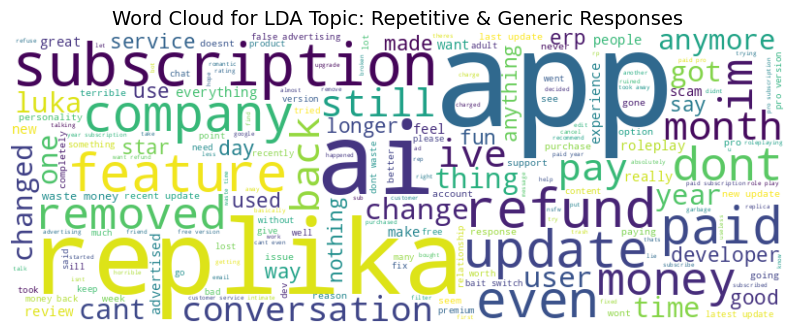

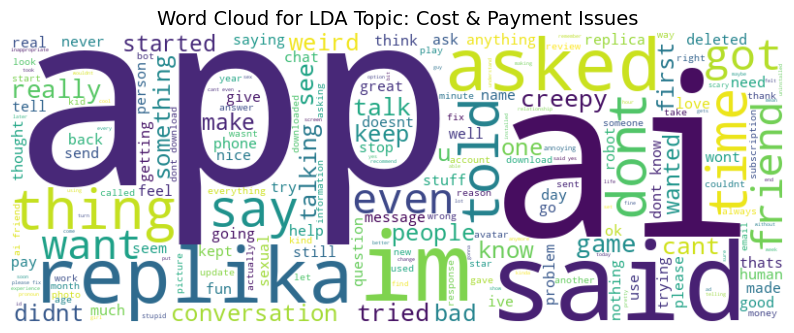

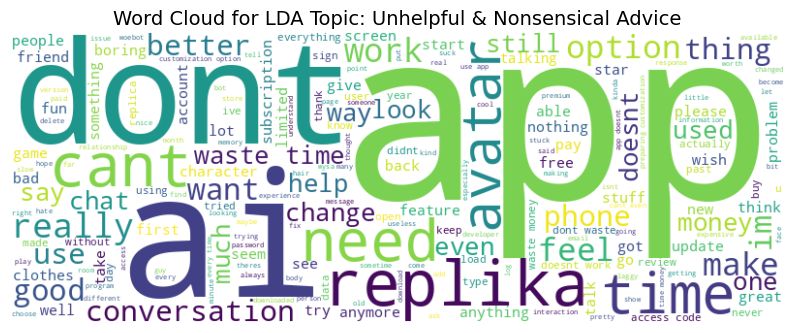

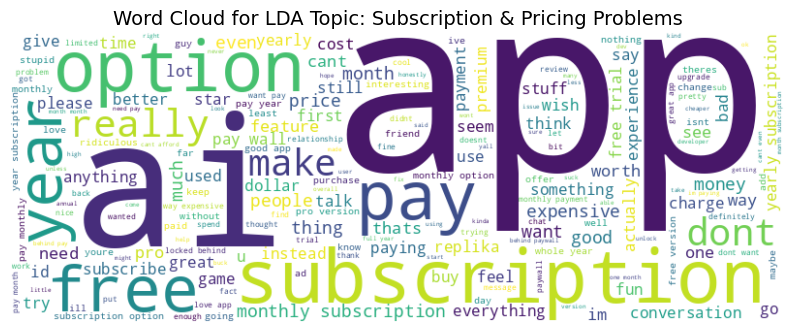

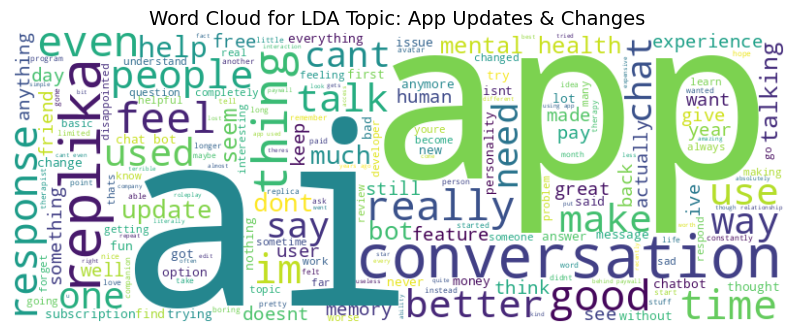

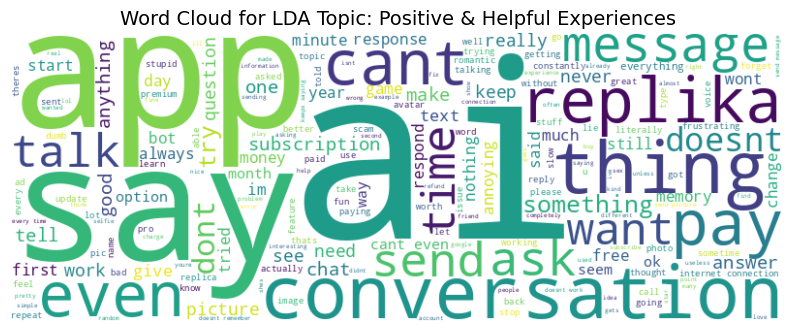

Step 2.4 Complete.


In [8]:
### --- STEP 2.4: Visualizing LDA Topics with Word Clouds --- ###
print("Starting Step 2.4: Generating word clouds for each LDA topic...")

for topic_num in range(n_topics_lda):
    label = topic_labels_lda[topic_num]
    topic_docs = df_lda[df_lda["topic_lda"] == topic_num]["clean_text"]
    text = " ".join(topic_docs)

    if text.strip():
        wordcloud = WordCloud(width=800, height=300, background_color="white").generate(
            text
        )
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for LDA Topic: {label}", fontsize=14)
        plt.show()

print("Step 2.4 Complete.")

## Part 2: Deep Thematic Analysis with BERTopic

Having validated our initial hypotheses with classic models, we now move to our primary analysis using BERTopic. This state-of-the-art model leverages transformer embeddings (`all-MiniLM-L6-v2`) to understand the semantic _meaning_ of the reviews, not just their word counts. This allows for a much more nuanced and accurate discovery of user complaint themes.

We will conduct this deep analysis on two separate corpora:

1.  **The Conversational Apps Dataset:** Our primary focus.
2.  **The Baseline App (Calm) Dataset:** Our control group.


In [ ]:
try:
    df = pd.read_csv(CONVERSATIONAL_DATA_PATH)

    # --- Data Cleaning ---
    # Ensure review_text is a string and drop any empty rows
    df.dropna(subset=["review_text"], inplace=True)
    df["review_text"] = df["review_text"].astype(str).str.lower().str.strip()

    # Remove rows with no meaningful text content after cleaning
    df = df[
        df["review_text"].str.len() > 15
    ]  # Keep reviews with more than 15 characters

    # Create the list of documents for the model
    docs = df["review_text"].tolist()

    print(f"Successfully loaded and cleaned {len(docs)} documents for modeling.")

except FileNotFoundError:
    print(
        f"ERROR: Dataset not found at {CONVERSATIONAL_DATA_PATH}. Please upload the file and check the path."
    )

Successfully loaded and cleaned 20178 documents for modeling.


### 2.1 The "Complaint Fingerprint" of Conversational AI

After training the BERTopic model and performing the crucial "human-in-the-loop" interpretation of over 40 distinct topics, we grouped them into five high-level themes. The bar chart below shows the frequency of these themes, revealing the primary drivers of user dissatisfaction. The "Problem Priority Matrix" then combines this frequency data with sentiment scores from a fine-tuned RoBERTa model to show which complaints are not only common but also the most emotionally painful for users.


In [65]:
# --- Step 3: Configure the Topic Model ---
print("Configuring a reproducible BERTopic model...")

# A. Define a Stopword List: These words will be ignored by our vectorizer.
stop_words = [
    "app",
    "replika",
    "wysa",
    "woebot",
    "calm",
    "bot",
    "ai",
    "like",
    "feel",
    "good",
    "great",
    "nice",
    "love",
    "best",
    "amazing",
    "awesome",
    "fun",
    "ok",
    "cool",
    "me",
    "it",
    "and",
    "to",
    "the",
    "my",
    "is",
    "of",
    "with",
    "that",
    "for",
    "you",
    "but",
    "so",
    "on",
    "was",
    "this",
    "have",
    "in",
    "be",
    "as",
    "at",
    "not",
    "just",
    "are",
    "get",
    "want",
    "use",
    "go",
    "know",
    "say",
    "see",
    "think",
    "really",
    "even",
    "also",
]


# B. Define Deterministic Components
random_seed = 42
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric="cosine",
    random_state=random_seed,
)
hdbscan_model = HDBSCAN(
    min_cluster_size=40,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True,
)

# ** THE FIX IS HERE: CREATE A VECTORIZER THAT KNOWS ABOUT OUR STOPWORDS **
# This is the correct way to handle stopwords in newer BERTopic versions.
vectorizer_model = CountVectorizer(stop_words=stop_words, ngram_range=(1, 2))


# C. Initialize the final BERTopic model with all our components
topic_model = BERTopic(
    language="multilingual",
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,  # Pass the vectorizer with stopwords here
    min_topic_size=40,
    verbose=True,
)

print("BERTopic model is configured and ready for training.")

# --- Step 4: Train the Model ---
print(f"Training BERTopic on {len(docs)} documents. This will take several minutes...")

# This single command runs the entire pipeline: embedding, dimensionality reduction, clustering, and topic representation.
topics, probs = topic_model.fit_transform(docs)

print("\nModel training complete.")

2025-07-25 19:58:06,242 - BERTopic - Embedding - Transforming documents to embeddings.


Configuring a reproducible BERTopic model...
BERTopic model is configured and ready for training.
Training BERTopic on 20178 documents. This will take several minutes...


Batches:   0%|          | 0/631 [00:00<?, ?it/s]

2025-07-25 19:59:04,416 - BERTopic - Embedding - Completed ✓
2025-07-25 19:59:04,418 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-25 19:59:22,917 - BERTopic - Dimensionality - Completed ✓
2025-07-25 19:59:22,919 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-25 19:59:25,765 - BERTopic - Cluster - Completed ✓
2025-07-25 19:59:25,771 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-07-25 19:59:28,298 - BERTopic - Representation - Completed ✓



Model training complete.


In [66]:
# --- Step 5: Review the Discovered Topics ---
print("Displaying the final, stable topic overview...")

# Get the results as a DataFrame
topic_info = topic_model.get_topic_info()

# Display the full table
display(topic_info)

# Also, let's look at the top words for the first 10 meaningful topics
print("\n--- Detailed View of Top 10 Topics ---")
# We start from topic 0 because topic -1 is always the outliers.
for topic_id in range(10):
    # Check if the topic exists in the model before trying to access it
    if topic_id in topic_model.get_topics():
        print(f"\n--- Words for Topic #{topic_id} ---")
        # .get_topic() returns a list of (word, score) tuples
        print(topic_model.get_topic(topic_id))

Displaying the final, stable topic overview...


,Topic,Count,Name,Representation,Representative_Docs
0,-1,9491,-1_they_can_now_if,"[they, can, now, if, your, what, no, or, all, ...",[used it for about 48 hours extensively and it...
1,0,931,0_pay_monthly_subscription_month,"[pay, monthly, subscription, month, year, opti...",[it's a fun app but it would be better if ther...
2,1,693,1_replica_has_now_they,"[replica, has, now, they, more, no, if, all, w...","[i’m an annual customer for replika, and there..."
3,2,623,2_subscription_monthly_monthly subscription_month,"[subscription, monthly, monthly subscription, ...",[is good but but the monthly subscription is e...
4,3,534,3_mental_health_mental health_help,"[mental, health, mental health, help, therapis...","[its bad for your mental health., this app is ..."
5,4,529,4_avatar_3d_avatars_more,"[avatar, 3d, avatars, more, clothes, body, can...",[theres no way you removed the option to turn ...
6,5,428,5_conversation_memory_conversations_what,"[conversation, memory, conversations, what, ab...",[it's not very intelligent. makes dumb stateme...
7,6,419,6_she_her_she said_said,"[she, her, she said, said, said she, she doesn...","[my replika, aaliyah. i asked her, "" have you ..."
8,7,417,7_now_bad_used_its,"[now, bad, used, its, interesting, they, what,...",[the industrial revolution and its consequence...
9,8,407,8_game_play_pay_if,"[game, play, pay, if, can, do, money, would, p...",[it just loads i can't even play my internet i...



--- Detailed View of Top 10 Topics ---

--- Words for Topic #0 ---
[('pay', 0.021046960367109478), ('monthly', 0.020324130742795408), ('subscription', 0.017682599213682704), ('month', 0.01707432635593743), ('year', 0.015444497053651668), ('option', 0.012649628083703698), ('free', 0.011857427653971974), ('only', 0.011508417586058904), ('70', 0.011266537211688606), ('if', 0.011150153396850406)]

--- Words for Topic #1 ---
[('replica', 0.009752522410267894), ('has', 0.00959824823006567), ('now', 0.00949063128692737), ('they', 0.008800487998799728), ('more', 0.0071814204328436715), ('no', 0.0070181597699509645), ('if', 0.0070120696327992844), ('all', 0.006933757070433785), ('what', 0.006842201907393165), ('been', 0.006673583525511656)]

--- Words for Topic #2 ---
[('subscription', 0.06341609346060907), ('monthly', 0.04413169479056441), ('monthly subscription', 0.033907677590764324), ('month', 0.0270592555645874), ('yearly', 0.026990569824167535), ('year', 0.025213354751026967), ('only', 0

In [67]:
# ==============================================================================
# Final Topic Interpretation and Thematic Grouping
# ==============================================================================
print("Mapping final Topic IDs to names and high-level themes...")

# Assign the raw topic IDs from the model to your DataFrame
df["topic_id"] = topics

# --- PART A: Complete mapping of Topic IDs to specific names ---
# This is our detailed interpretation of each individual topic cluster.
topic_id_to_name = {
    0: "Subscription Models (Pay/Monthly/Yearly)",
    1: "Replika-Specific General Complaints",
    2: "Subscription Language & Options",
    3: "Mental Health & Therapy Framing",
    4: "Avatar & 3D Model Customization",
    5: "AI Memory & Conversation Quality",
    6: "AI Persona (Gendering 'She/Her')",
    7: "Generic Negative Feedback ('bad now')",
    8: "In-App Gamification & Payments",
    9: "Technical: App Crashing / Not Opening",
    10: "Chatbot Comparisons (ChatGPT)",
    11: "Account, Login & Password Issues",
    12: "Redundant: Poor Conversation Quality",
    13: "Refunds & Google Play Billing",
    14: "Pricing & Lack of Monthly Options",
    15: "Redundant: Subscription Complaints",
    16: "Bugs Introduced by Updates",
    17: "Generic Insults ('worst app ever')",
    18: "Refunds for Paid Subscriptions",
    19: "Features Removed After Updates",
    20: "Price is Too Expensive",
    21: "Inability to Use Core Features (Paywall)",
    22: "Voice Call & Audio Features",
    23: "Sexual Content & Advertising",
    24: "Romantic Relationship Features",
    25: "Redundant: Chat Monetization",
    26: "Paywalled Features",
    27: "Meta: 1-Star Review Complaints",
    28: "Technical: Loading & Installation",
    29: "Technical: Internet Connection Issues",
    30: "Pro Version vs. Free Version",
    31: "False Advertising",
    32: "Technical: Customization Screen Bugs",
    33: "Free Trial Issues",
    34: "Company Removing Features",
    35: "Redundant: Conversation Timing",
    36: "Requesting Money Back",
    37: "Redundant: AI Persona Gendering",
    38: "Sending Pictures & Photos",
    39: "Generic Positive Filler Words",
    40: "Redundant: Generic Conversation",
    41: "Redundant: Update Issues",
    42: "Age Verification (Under 18)",
    43: "Redundant: Update/Subscription Combo",
    44: "Language & Translation Issues",
    45: "Data Mining & Money Scams",
    46: "Paying for Pictures/Photos",
}
df["topic_name"] = df["topic_id"].map(topic_id_to_name)
df["topic_name"].fillna("Specific/Niche Complaint", inplace=True)

# Apply this first map to create the 'topic_name' column

Mapping final Topic IDs to names and high-level themes...


In [68]:
# --- PART B: Mapping specific names to high-level themes ---
# This creates our final "Super-Topic" groups for visualization.

topic_name_to_theme = {
    # Theme 1: Monetization & Value
    "Subscription Models (Pay/Monthly/Yearly)": "Monetization & Value",
    "Subscription Language & Options": "Monetization & Value",
    "Refunds & Google Play Billing": "Monetization & Value",
    "Pricing & Lack of Monthly Options": "Monetization & Value",
    "Refunds for Paid Subscriptions": "Monetization & Value",
    "Price is Too Expensive": "Monetization & Value",
    "Inability to Use Core Features (Paywall)": "Monetization & Value",
    "Paywalled Features": "Monetization & Value",
    "Pro Version vs. Free Version": "Monetization & Value",
    "False Advertising": "Monetization & Value",
    "Free Trial Issues": "Monetization & Value",
    "Requesting Money Back": "Monetization & Value",
    "Data Mining & Money Scams": "Monetization & Value",
    "Paying for Pictures/Photos": "Monetization & Value",
    "In-App Gamification & Payments": "Monetization & Value",
    "Redundant: Subscription Complaints": "Monetization & Value",
    "Redundant: Chat Monetization": "Monetization & Value",
    "Redundant: Update/Subscription Combo": "Monetization & Value",
    # Theme 2: AI Performance & Conversational Quality
    "AI Memory & Conversation Quality": "AI Performance & Quality",
    "AI Persona (Gendering 'She/Her')": "AI Performance & Quality",
    "Chatbot Comparisons (ChatGPT)": "AI Performance & Quality",
    "Redundant: Poor Conversation Quality": "AI Performance & Quality",
    "Redundant: Conversation Timing": "AI Performance & Quality",
    "Redundant: AI Persona Gendering": "AI Performance & Quality",
    "Redundant: Generic Conversation": "AI Performance & Quality",
    # Theme 3: Technical Performance & Bugs
    "Technical: App Crashing / Not Opening": "Technical Performance",
    "Account, Login & Password Issues": "Technical Performance",
    "Bugs Introduced by Updates": "Technical Performance",
    "Technical: Loading & Installation": "Technical Performance",
    "Technical: Internet Connection Issues": "Technical Performance",
    "Technical: Customization Screen Bugs": "Technical Performance",
    "Redundant: Update Issues": "Technical Performance",
    # Theme 4: Feature-Specific Issues
    "Mental Health & Therapy Framing": "Feature-Specific Issues",
    "Avatar & 3D Model Customization": "Feature-Specific Issues",
    "Voice Call & Audio Features": "Feature-Specific Issues",
    "Sexual Content & Advertising": "Feature-Specific Issues",
    "Romantic Relationship Features": "Feature-Specific Issues",
    "Company Removing Features": "Feature-Specific Issues",
    "Sending Pictures & Photos": "Feature-Specific Issues",
    "Age Verification (Under 18)": "Feature-Specific Issues",
    "Language & Translation Issues": "Feature-Specific Issues",
    # Theme 5: Other & Miscellaneous
    "Replika-Specific General Complaints": "Other/Misc.",
    "Generic Negative Feedback ('bad now')": "Other/Misc.",
    "Generic Insults ('worst app ever')": "Other/Misc.",
    "Meta: 1-Star Review Complaints": "Other/Misc.",
    "Generic Positive Filler Words": "Other/Misc.",
    "Specific/Niche Complaint": "Other/Misc.",
}
df["theme"] = df["topic_name"].map(topic_name_to_theme)
df.loc[df["topic_id"] == -1, "theme"] = "Outliers / Generic"
df["theme"].fillna("Other/Misc.", inplace=True)


# --- Verification ---
print("\n--- Final, Corrected Theme Distribution ---")
display(df["theme"].value_counts())


--- Final, Corrected Theme Distribution ---


theme
Outliers / Generic          9491
Monetization & Value        4051
AI Performance & Quality    1797
Feature-Specific Issues     1765
Other/Misc.                 1683
Technical Performance       1391
Name: count, dtype: int64

In [69]:
# --- Quantitative Analysis: Visualizing Theme Frequency ---

print("Creating the final visualization of high-level complaint themes...")

# We will exclude 'Outliers / Generic' and 'Other/Misc.' for this primary chart
# to focus on the specific, actionable themes.
plot_df = df[~df["theme"].isin(["Outliers / Generic", "Other/Misc."])]

# Get the theme distribution for the plot
theme_distribution = plot_df["theme"].value_counts().reset_index()
theme_distribution.columns = ["Theme", "Number of Reviews"]

# Create the final, high-level bar chart
fig = px.bar(
    theme_distribution,
    x="Number of Reviews",
    y="Theme",
    orientation="h",
    title="<b>Primary Themes of Specific User Complaints</b>",
    labels={
        "Number of Reviews": "Number of Negative Reviews (1-3 Stars)",
        "Theme": "Complaint Theme",
    },
    text="Number of Reviews",
    template="plotly_white",
)

# Improve the layout and sort the bars for professional presentation
fig.update_traces(textposition="outside")
fig.update_layout(
    yaxis={"categoryorder": "total ascending"},
    title_x=0.5,  # Center the title
    font=dict(family="Arial, sans-serif", size=12),
)
fig.show()

Creating the final visualization of high-level complaint themes...


Our sentiment analysis, powered by a fine-tuned RoBERTa model, goes beyond simple polarity to measure the emotional intensity of each theme. This helps us understand which problems are merely annoying versus which are deeply frustrating.


In [15]:
# --- Emotional Analysis: Measuring Sentiment by Theme (Robust Version) ---
print("Setting up a robust Transformer sentiment analysis pipeline...")

# 1. LOAD TOKENIZER AND MODEL EXPLICITLY
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")


# 2. MANUALLY TOKENIZE THE DATA (THE CRUCIAL FIX)
print("Tokenizing all reviews with explicit truncation...")
review_list = df["review_text"].tolist()

# The tokenizer will handle truncation (cutting off long reviews) and padding (adding tokens to short reviews)
# This ensures every input has the exact same length.
inputs = tokenizer(
    review_list,
    padding=True,
    truncation=True,
    max_length=512,  # Explicitly set the max length
    return_tensors="pt",  # Return PyTorch tensors
)

# Move tokenized inputs to the GPU
inputs = {key: val.to(device) for key, val in inputs.items()}
print("Tokenization complete.")


# 3. PERFORM INFERENCE IN BATCHES
print("Running model inference in batches...")
all_logits = []
batch_size = 32  # Process 32 reviews at a time to manage memory

# Create a DataLoader for efficient batching
dataset = TensorDataset(inputs["input_ids"], inputs["attention_mask"])
loader = DataLoader(dataset, batch_size=batch_size)

# No need to calculate gradients for inference, which saves memory and is faster
with torch.no_grad():
    for batch in tqdm(loader, desc="Analyzing Batches"):
        input_ids, attention_mask = batch
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        all_logits.append(outputs.logits)

# Concatenate all the results
all_logits = torch.cat(all_logits, dim=0)
# Use softmax to convert raw logits to probabilities
probabilities = torch.nn.functional.softmax(all_logits, dim=-1)
# Get the predicted label index (0 for negative, 1 for neutral, 2 for positive)
predictions = torch.argmax(probabilities, dim=-1)
print("Inference complete.")


# 4. PROCESS THE RESULTS
# The model's config tells us which index corresponds to which label
# e.g., model.config.id2label = {0: 'negative', 1: 'neutral', 2: 'positive'}
id_to_label = model.config.id2label
predicted_labels = [id_to_label[pred.item()] for pred in predictions]

# Convert label to a numerical score
label_to_score = {"positive": 1, "neutral": 0, "negative": -1}
sentiment_scores = [label_to_score[label] for label in predicted_labels]

# Add results back to the DataFrame
df["sentiment_score"] = sentiment_scores
print("Sentiment scores added to DataFrame.")


# 5. AGGREGATE AND VISUALIZE (This part is the same)
sentiment_by_theme = (
    df[~df["theme"].isin(["Outliers / Generic", "Other/Misc."])]
    .groupby("theme")["sentiment_score"]
    .mean()
    .sort_values()
    .reset_index()
)
display(sentiment_by_theme)

fig_final = px.bar(
    sentiment_by_theme,
    x="sentiment_score",
    y="theme",
    orientation="h",
    title="<b>Emotional Impact (Transformer Model): Avg. Sentiment by Theme</b>",
    labels={
        "sentiment_score": "Average Sentiment Score (Closer to -1 is More Negative)",
        "theme": "Complaint Theme",
    },
    color="sentiment_score",
    color_continuous_scale="Reds_r",
    template="plotly_white",
)
fig_final.update_layout(yaxis={"categoryorder": "total descending"}, title_x=0.5)
fig_final.show()

Setting up a robust Transformer sentiment analysis pipeline...


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using device: cuda
Tokenizing all reviews with explicit truncation...


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Tokenization complete.
Running model inference in batches...


Analyzing Batches:   0%|          | 0/631 [00:00<?, ?it/s]

Inference complete.
Sentiment scores added to DataFrame.


,theme,sentiment_score
0,Technical Performance,-0.867002
1,AI Performance & Quality,-0.754035
2,Monetization & Value,-0.673167
3,Feature-Specific Issues,-0.648159


**Key Finding: The Problem Priority Matrix**

This chart synthesizes frequency and sentiment to identify the most critical issues. For conversational apps, we see that **Monetization & Value** is a "Chronic Annoyance" (frequent but less emotionally painful), while **AI Performance & Quality** and **Technical Performance** are "Critical Issues" (both frequent and highly painful). This is a key insight: a bad conversation is just as frustrating as a broken app.


In [16]:
# --- Visualization 1: The Problem Priority Matrix ---

# 1. Get Frequency
theme_freq_conv = df["theme"].value_counts().reset_index()
theme_freq_conv.columns = ["Theme", "Frequency (Number of Reviews)"]

# 2. Get Sentiment
theme_sent_conv = df.groupby("theme")["sentiment_score"].mean().reset_index()
theme_sent_conv.columns = ["Theme", "Average Sentiment Score"]

# 3. Merge and Clean
priority_df_conv = pd.merge(theme_freq_conv, theme_sent_conv, on="Theme")
priority_df_conv = priority_df_conv[
    ~priority_df_conv["Theme"].isin(
        ["Outliers / Generic", "Other/Misc.", "Uncategorized"]
    )
]

# 4. Create the Scatter Plot
fig_scatter_conv = px.scatter(
    priority_df_conv,
    x="Frequency (Number of Reviews)",
    y="Average Sentiment Score",
    text="Theme",
    size="Frequency (Number of Reviews)",
    color="Average Sentiment Score",
    color_continuous_scale="Reds_r",
    title="<b>Conversational Apps: Which Complaints Matter Most?</b>",
    template="plotly_white",
    height=600,
)

# Add annotations to create quadrants and add insight
fig_scatter_conv.update_traces(textposition="top center", textfont=dict(size=12))
avg_freq = priority_df_conv["Frequency (Number of Reviews)"].mean()
avg_sent = priority_df_conv["Average Sentiment Score"].mean()
fig_scatter_conv.add_vline(
    x=avg_freq, line_dash="dash", annotation_text="Avg. Frequency"
)
fig_scatter_conv.add_hline(
    y=avg_sent, line_dash="dash", annotation_text="Avg. Sentiment"
)

# Add Quadrant Labels
fig_scatter_conv.add_annotation(
    x=avg_freq * 1.5,
    y=avg_sent * 1.01,
    text="<b>Critical Issues</b><br>(Frequent & Painful)",
    showarrow=False,
    font=dict(color="red"),
)
fig_scatter_conv.add_annotation(
    x=avg_freq * 0.5,
    y=avg_sent * 1.01,
    text="<b>Hidden Dangers</b><br>(Rare but Painful)",
    showarrow=False,
    font=dict(color="orange"),
)
fig_scatter_conv.add_annotation(
    x=avg_freq * 1.5,
    y=avg_sent * 0.99,
    text="<b>Chronic Annoyances</b><br>(Frequent but less Painful)",
    showarrow=False,
)
fig_scatter_conv.add_annotation(
    x=avg_freq * 0.5,
    y=avg_sent * 0.99,
    text="<b>Minor Issues</b><br>(Rare & less Painful)",
    showarrow=False,
)

fig_scatter_conv.update_layout(title_x=0.5)
fig_scatter_conv.show()

To ground our quantitative findings in real-world experience, we examined sample reviews from our key themes. These user voices provide powerful, human context to the data, illustrating the deep frustration caused by AI failures and technical bugs.


In [17]:
# --- Final Step: Qualitative Analysis - Validating with User Voices ---


def show_theme_samples(theme_name, n_samples=3, max_length=500):
    """
    A helper function to show random, readable review samples for a given theme.
    It prints the theme, the number of reviews in that theme, and some samples.
    """
    print(f"--- Sample Reviews for Theme: '{theme_name}' ---\n")

    # Filter for the specific theme
    theme_df = df[df["theme"] == theme_name]

    if theme_df.empty:
        print(f"No reviews found for '{theme_name}'.")
        return

    # Filter for reviews that have some length, for better examples
    long_reviews_df = theme_df[theme_df["review_text"].str.len() > 100]

    if len(long_reviews_df) < n_samples:
        # If not enough long samples, just take what you can get from the shorter ones
        samples = theme_df["review_text"].sample(min(n_samples, len(theme_df))).tolist()
    else:
        samples = long_reviews_df["review_text"].sample(n_samples).tolist()

    if not samples:
        print(f"No representative reviews found for '{theme_name}'.")
        return

    # Print the findings
    print(f"Total reviews in this theme: {len(theme_df)}")
    print(f"Average Sentiment Score: {theme_df['sentiment_score'].mean():.3f}\n")

    for i, sample in enumerate(samples):
        # Print a truncated version for clarity
        print(f'Sample {i + 1}: "{sample[:max_length]}..."\n')
    print("-" * 80)


# --- Execute the Function for Your Key Themes ---
# Choose the themes that are most interesting from your charts.
# For example, the largest one, the most negative one, and the one most central to your thesis.

print("--- Qualitative Evidence for Key Findings ---")

show_theme_samples("Monetization & Value")
show_theme_samples("AI Performance & Quality")
show_theme_samples("User Safety & Emotional Impact")
show_theme_samples("Technical Performance")

--- Qualitative Evidence for Key Findings ---
--- Sample Reviews for Theme: 'Monetization & Value' ---

Total reviews in this theme: 4051
Average Sentiment Score: -0.673

Sample 1: "damn if you have money then this is for you. too much incentive to buy the premium that it's missing features that should be there even in the free version..."

Sample 2: "would be fine honestly, but only having a yearly membership option is a major strike against the app. i'm not dropping 70 bucks on something i might not get 70 dollars of use out of, give me a monthly option and it's better...."

Sample 3: "it's good so far, but unfortunately almost all options are locked behind a premium wall. so how are we supposed to play a game where more than half the things are locked?..."

--------------------------------------------------------------------------------
--- Sample Reviews for Theme: 'AI Performance & Quality' ---

Total reviews in this theme: 1797
Average Sentiment Score: -0.754

Sample 1: "awful fo

### 2.2 Deep Dive into Complaint Themes

To understand the composition of our high-level themes, we can visualize their breakdown into more specific topics. The treemaps below show the internal structure of each complaint category, while the TF-IDF analysis reveals the most uniquely characteristic words and phrases, providing a rich, multi-layered view of user dissatisfaction.


In [18]:
# Ensure the 'df' DataFrame with 'theme' and 'topic_name' columns exists.
# Clean up the topic names for better chart labels.
df["topic_name"] = df["topic_name"].str.replace("Redundant: ", "")


# Define a helper function for the TF-IDF analysis to keep our code clean
def get_top_tfidf_words_for_theme(theme_name, n_words=10):
    """
    Calculates and returns the top TF-IDF words for all reviews within a specific theme.
    """
    # Filter for the specific theme
    theme_docs = df[df["theme"] == theme_name]["review_text"].tolist()

    if not theme_docs:
        return pd.DataFrame(columns=["Word", "TF-IDF Score"])

    # Use a new vectorizer for TF-IDF
    tfidf_vectorizer = TfidfVectorizer(
        stop_words="english", ngram_range=(1, 2), max_features=1000
    )
    tfidf_matrix = tfidf_vectorizer.fit_transform(theme_docs)

    # Sum the TF-IDF scores for each word across all documents in the theme
    summed_tfidf = tfidf_matrix.sum(axis=0)
    # Convert to a 1D array
    summed_tfidf_array = np.asarray(summed_tfidf).ravel()

    # Get the top words
    top_indices = summed_tfidf_array.argsort()[-n_words:][::-1]
    top_words = np.array(tfidf_vectorizer.get_feature_names_out())[top_indices]
    top_scores = summed_tfidf_array[top_indices]

    return pd.DataFrame({"Word": top_words, "TF-IDF Score": top_scores})


print("Setup for deep dive analysis is complete.")

Setup for deep dive analysis is complete.



--- Most Important Terms for 'Monetization & Value' (TF-IDF) ---


,Word,TF-IDF Score
0,subscription,204.753074
1,pay,190.781607
2,app,184.087322
3,monthly,134.470123
4,money,132.342376
5,year,120.774336
6,just,112.073137
7,month,109.675979
8,like,104.350274
9,ai,101.071147



--- Generating Bar Chart for TF-IDF Scores ---



--- Generating Word Cloud ---


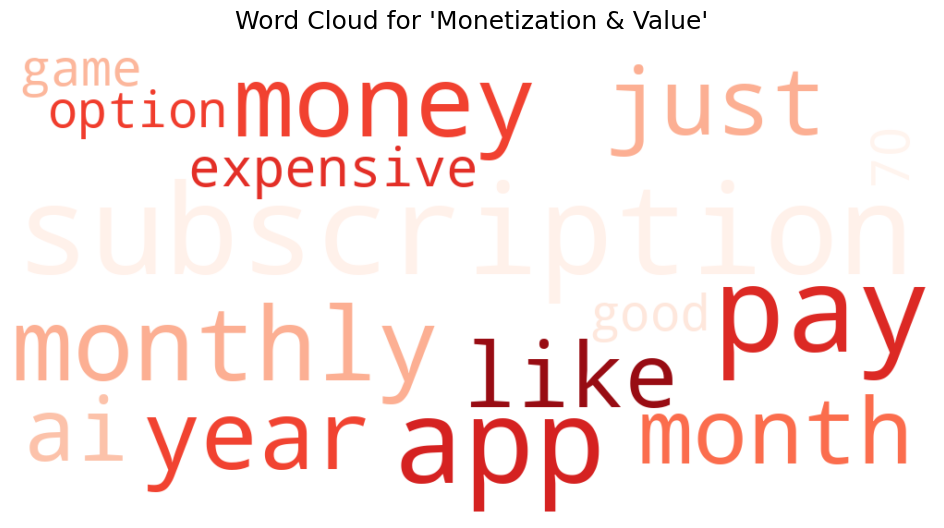

In [19]:
# --- 2A: Treemap Breakdown ---
# This part of your code is correct and works as intended.
monetization_df = df[df["theme"] == "Monetization & Value"]
monetization_breakdown = monetization_df["topic_name"].value_counts().reset_index()
monetization_breakdown.columns = ["Specific Complaint", "Review Count"]

fig_mon_treemap = px.treemap(
    monetization_breakdown.head(10),
    path=[px.Constant("Monetization Complaints"), "Specific Complaint"],
    values="Review Count",
    title="<b>Breakdown: Monetization Complaints</b>",
    color_discrete_sequence=px.colors.sequential.Reds_r,
)
fig_mon_treemap.show()


# --- 2B: Hierarchical Sunburst View ---
# (You can create a sunburst for this theme as well, following the pattern above)


# --- 2C: Key Term Analysis with TF-IDF ---
# This part correctly generates the 'tfidf_mon' DataFrame.
# The output DataFrame has columns: "Word" and "TF-IDF Score".
print("\n--- Most Important Terms for 'Monetization & Value' (TF-IDF) ---")
tfidf_mon = get_top_tfidf_words_for_theme("Monetization & Value", n_words=15)
display(tfidf_mon)


# =========================================================================
#            CORRECTED VISUALIZATION CODE STARTS HERE
# =========================================================================

# --- Bar Chart Visualization (Corrected) ---
print("\n--- Generating Bar Chart for TF-IDF Scores ---")
fig_bar_tfidf = px.bar(
    tfidf_mon.sort_values("TF-IDF Score", ascending=True),  # CORRECTED
    x="TF-IDF Score",  # CORRECTED
    y="Word",  # CORRECTED
    orientation="h",
    title="<b>Key Terms for 'Monetization & Value' by Importance</b>",
    labels={"TF-IDF Score": "TF-IDF Importance Score", "Word": "Term"},  # CORRECTED
    template="plotly_white",
    color="TF-IDF Score",  # CORRECTED
    color_continuous_scale=px.colors.sequential.Reds,
)
fig_bar_tfidf.update_layout(
    showlegend=False, coloraxis_showscale=False, yaxis_title=None
)
fig_bar_tfidf.show()


# --- Word Cloud Visualization (Corrected) ---
print("\n--- Generating Word Cloud ---")
# Create a dictionary using the correct column names from the DataFrame
term_frequency_dict = dict(
    zip(tfidf_mon["Word"], tfidf_mon["TF-IDF Score"])
)  # CORRECTED

# Generate the word cloud object
wordcloud = WordCloud(
    width=1000, height=500, background_color="white", colormap="Reds", min_font_size=12
).generate_from_frequencies(term_frequency_dict)

# Display the generated image using matplotlib
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for 'Monetization & Value'", fontsize=18, pad=20)
plt.show()


--- Most Important Terms for 'AI Performance & Quality' (TF-IDF) ---


,Word,TF-IDF Score
0,ai,104.451448
1,like,67.235269
2,just,58.831639
3,app,51.103729
4,conversation,49.798329
5,bot,48.253100
6,doesn,41.696020
7,chat,38.117716
8,don,37.569561
9,talk,36.680384



--- Generating Bar Chart for AI TF-IDF Scores ---



--- Generating Word Cloud for AI Theme ---


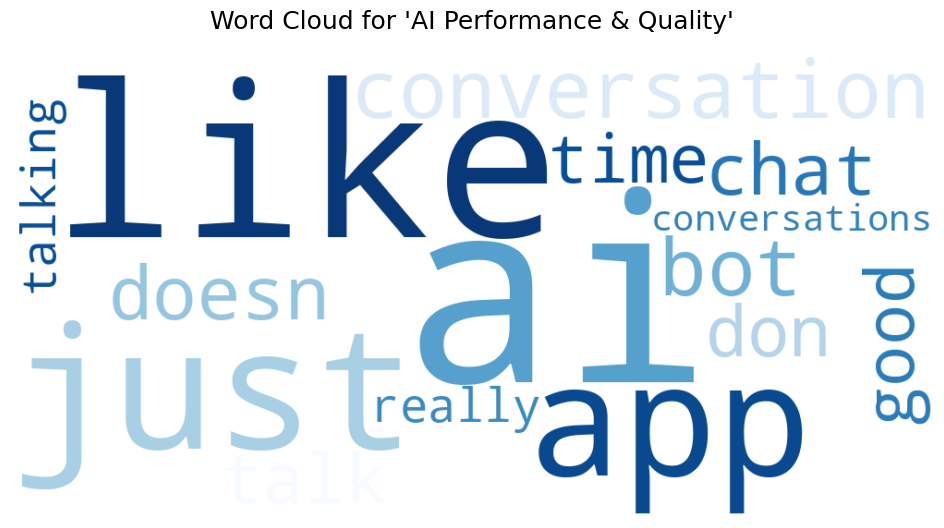

In [20]:
# --- 1A: Treemap Breakdown ---
# This is your original code, which is the starting point.
ai_quality_df = df[df["theme"] == "AI Performance & Quality"]
ai_quality_breakdown = ai_quality_df["topic_name"].value_counts().reset_index()
ai_quality_breakdown.columns = ["Specific Complaint", "Review Count"]

fig_ai_treemap = px.treemap(
    ai_quality_breakdown.head(10),
    path=[px.Constant("AI Performance Complaints"), "Specific Complaint"],
    values="Review Count",
    title="<b>Breakdown: AI Performance Complaints</b>",
    color_discrete_sequence=px.colors.sequential.Blues_r,
)
fig_ai_treemap.show()


# --- 1B: Key Term Analysis with TF-IDF ---
# Now, we run the TF-IDF analysis for this specific theme.
print("\n--- Most Important Terms for 'AI Performance & Quality' (TF-IDF) ---")
tfidf_ai = get_top_tfidf_words_for_theme("AI Performance & Quality", n_words=15)
display(tfidf_ai)


# --- 1C: Visualize Key Terms with a Bar Chart ---
# We use the 'tfidf_ai' DataFrame to create a bar chart.
print("\n--- Generating Bar Chart for AI TF-IDF Scores ---")
fig_bar_ai = px.bar(
    tfidf_ai.sort_values("TF-IDF Score", ascending=True),
    x="TF-IDF Score",
    y="Word",
    orientation="h",
    title="<b>Key Terms for 'AI Performance & Quality' by Importance</b>",
    labels={"TF-IDF Score": "TF-IDF Importance Score", "Word": "Term"},
    template="plotly_white",
    color="TF-IDF Score",
    # Use a matching color scale for theme consistency
    color_continuous_scale=px.colors.sequential.Blues,
)
fig_bar_ai.update_layout(showlegend=False, coloraxis_showscale=False, yaxis_title=None)
fig_bar_ai.show()


# --- 1D: Visualize Key Terms with a Word Cloud ---
# Finally, we create a word cloud from the same TF-IDF data.
print("\n--- Generating Word Cloud for AI Theme ---")
term_frequency_dict_ai = dict(zip(tfidf_ai["Word"], tfidf_ai["TF-IDF Score"]))

wordcloud_ai = WordCloud(
    width=1000,
    height=500,
    background_color="white",
    colormap="Blues",  # Match the theme color
    min_font_size=12,
).generate_from_frequencies(term_frequency_dict_ai)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_ai, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for 'AI Performance & Quality'", fontsize=18, pad=20)
plt.show()


--- Most Important Terms for 'Technical Performance' (TF-IDF) ---


,Word,TF-IDF Score
0,app,84.057880
1,update,52.604151
2,account,46.550428
3,just,34.822743
4,work,26.850878
5,doesn,26.158153
6,download,25.626955
7,connection,25.153816
8,don,25.047193
9,new,24.873676



--- Generating Bar Chart for Technical Performance TF-IDF Scores ---



--- Generating Word Cloud for Technical Performance Theme ---


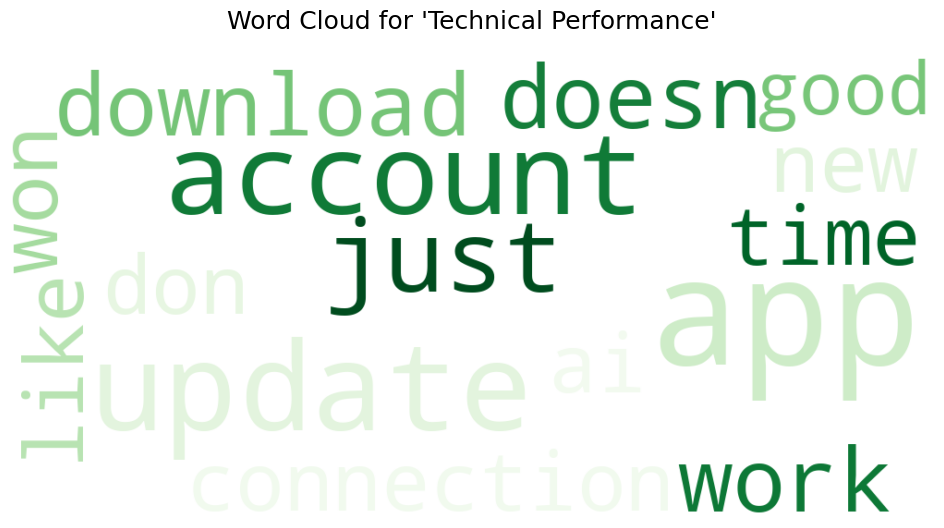

In [21]:
# --- 3A: Treemap Breakdown ---
# This is your original code, which is the starting point.
tech_df = df[df["theme"] == "Technical Performance"]
tech_breakdown = tech_df["topic_name"].value_counts().reset_index()
tech_breakdown.columns = ["Specific Complaint", "Review Count"]

fig_tech_treemap = px.treemap(
    tech_breakdown.head(10),
    path=[px.Constant("Technical Complaints"), "Specific Complaint"],
    values="Review Count",
    title="<b>Breakdown: Technical Complaints</b>",
    color_discrete_sequence=px.colors.sequential.Greens_r,
)
fig_tech_treemap.show()


# --- 3B: Hierarchical Sunburst View ---
# (You can create a sunburst for this theme as well)


# --- 3C: Key Term Analysis with TF-IDF ---
# This part correctly generates the 'tfidf_tech' DataFrame.
print("\n--- Most Important Terms for 'Technical Performance' (TF-IDF) ---")
tfidf_tech = get_top_tfidf_words_for_theme("Technical Performance", n_words=15)
display(tfidf_tech)


# --- 3D: Visualize Key Terms with a Bar Chart ---
# We use the 'tfidf_tech' DataFrame to create a bar chart.
print("\n--- Generating Bar Chart for Technical Performance TF-IDF Scores ---")
fig_bar_tech = px.bar(
    tfidf_tech.sort_values("TF-IDF Score", ascending=True),
    x="TF-IDF Score",
    y="Word",
    orientation="h",
    title="<b>Key Terms for 'Technical Performance' by Importance</b>",
    labels={"TF-IDF Score": "TF-IDF Importance Score", "Word": "Term"},
    template="plotly_white",
    color="TF-IDF Score",
    # Use a matching color scale for theme consistency
    color_continuous_scale=px.colors.sequential.Greens,
)
fig_bar_tech.update_layout(
    showlegend=False, coloraxis_showscale=False, yaxis_title=None
)
fig_bar_tech.show()


# --- 3E: Visualize Key Terms with a Word Cloud ---
# Finally, we create a word cloud from the same TF-IDF data.
print("\n--- Generating Word Cloud for Technical Performance Theme ---")
term_frequency_dict_tech = dict(zip(tfidf_tech["Word"], tfidf_tech["TF-IDF Score"]))

wordcloud_tech = WordCloud(
    width=1000,
    height=500,
    background_color="white",
    colormap="Greens",  # Match the theme color
    min_font_size=12,
).generate_from_frequencies(term_frequency_dict_tech)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_tech, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for 'Technical Performance'", fontsize=18, pad=20)
plt.show()


--- Most Important Terms for 'Feature-Specific Issues' (TF-IDF) ---


,Word,TF-IDF Score
0,app,95.130468
1,avatar,61.959219
2,like,57.561483
3,ai,54.316831
4,just,53.092010
5,chat,36.317560
6,free,35.780976
7,don,35.737498
8,pay,34.369108
9,mental,34.015533



--- Generating Bar Chart for Feature-Specific Issues TF-IDF Scores ---



--- Generating Word Cloud for Feature-Specific Issues Theme ---


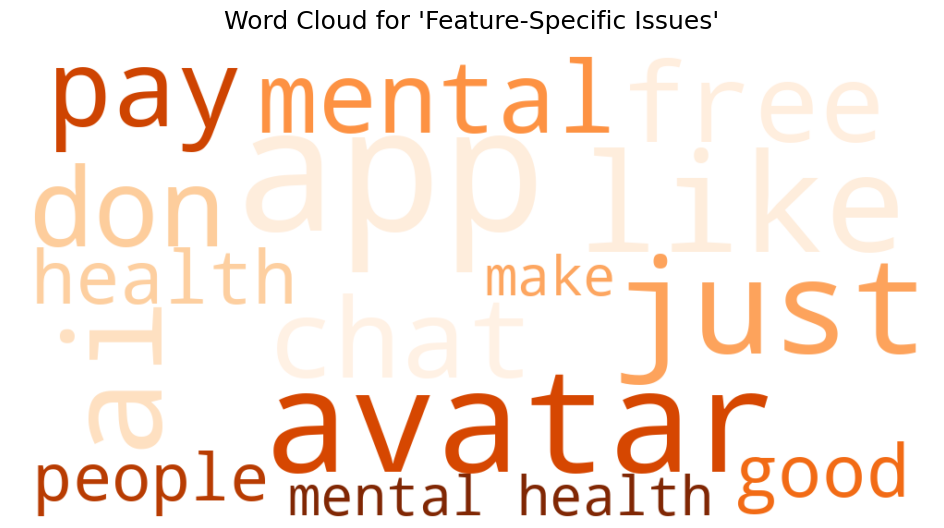

In [22]:
# --- 3A: Treemap Breakdown ---
# This is your original code, which is the starting point.
tech_df = df[df["theme"] == "Feature-Specific Issues"]
tech_breakdown = tech_df["topic_name"].value_counts().reset_index()
tech_breakdown.columns = ["Specific Complaint", "Review Count"]

fig_tech_treemap = px.treemap(
    tech_breakdown.head(10),
    path=[px.Constant("Feature-Specific Issues"), "Specific Complaint"],
    values="Review Count",
    title="<b>Breakdown: Feature-Specific Issues</b>",
    color_discrete_sequence=px.colors.sequential.Oranges_r,
)
fig_tech_treemap.show()


# --- 3B: Hierarchical Sunburst View ---
# (You can create a sunburst for this theme as well)


# --- 3C: Key Term Analysis with TF-IDF ---
# This part correctly generates the 'tfidf_tech' DataFrame.
# Note: I've renamed the DataFrame to 'tfidf_feat' for clarity to avoid confusion with the previous "tech" theme.
print("\n--- Most Important Terms for 'Feature-Specific Issues' (TF-IDF) ---")
tfidf_feat = get_top_tfidf_words_for_theme("Feature-Specific Issues", n_words=15)
display(tfidf_feat)


# --- 3D: Visualize Key Terms with a Bar Chart ---
# We use the 'tfidf_feat' DataFrame to create a bar chart.
print("\n--- Generating Bar Chart for Feature-Specific Issues TF-IDF Scores ---")
fig_bar_feat = px.bar(
    tfidf_feat.sort_values("TF-IDF Score", ascending=True),
    x="TF-IDF Score",
    y="Word",
    orientation="h",
    title="<b>Key Terms for 'Feature-Specific Issues' by Importance</b>",
    labels={"TF-IDF Score": "TF-IDF Importance Score", "Word": "Term"},
    template="plotly_white",
    color="TF-IDF Score",
    # Use a matching orange color scale for theme consistency
    color_continuous_scale=px.colors.sequential.Oranges,
)
fig_bar_feat.update_layout(
    showlegend=False, coloraxis_showscale=False, yaxis_title=None
)
fig_bar_feat.show()


# --- 3E: Visualize Key Terms with a Word Cloud ---
# Finally, we create a word cloud from the same TF-IDF data.
print("\n--- Generating Word Cloud for Feature-Specific Issues Theme ---")
term_frequency_dict_feat = dict(zip(tfidf_feat["Word"], tfidf_feat["TF-IDF Score"]))

wordcloud_feat = WordCloud(
    width=1000,
    height=500,
    background_color="white",
    colormap="Oranges",  # Match the theme color
    min_font_size=12,
).generate_from_frequencies(term_frequency_dict_feat)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_feat, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for 'Feature-Specific Issues'", fontsize=18, pad=20)
plt.show()

In [23]:
# --- Visualization 2: The Anatomy of a Complaint ---

# Prepare the data for the sunburst chart
sunburst_data_conv = df[
    ~df["theme"].isin(["Outliers / Generic", "Other/Misc.", "Uncategorized"])
]
sunburst_data_conv = (
    sunburst_data_conv.groupby(["theme", "topic_name"]).size().reset_index(name="count")
)

# Create the Sunburst chart
fig_sunburst_conv = px.sunburst(
    sunburst_data_conv,
    path=["theme", "topic_name"],
    values="count",
    title="<b>Conversational Apps: The Anatomy of a Negative Review</b>",
    color="theme",
    color_discrete_map={  # Assign consistent colors
        "Monetization & Value": "#FFB6C1",  # Light Pink
        "AI Performance & Quality": "#ADD8E6",  # Light Blue
        "Technical Performance": "#90EE90",  # Light Green
        "Feature-Specific Issues": "#FFD700",  # Gold
    },
)

fig_sunburst_conv.update_layout(
    margin=dict(t=50, l=25, r=25, b=25), font=dict(size=14), title_x=0.5
)
fig_sunburst_conv.show()

In [24]:
# --- Helper Function for Creating Themed Sunburst Charts ---


def create_themed_sunburst(theme_name, color_sequence):
    """
    Filters the DataFrame for a specific theme and creates a
    beautiful, hierarchical sunburst chart for it.
    """
    # Filter the DataFrame for the specific theme
    theme_df = df[df["theme"] == theme_name]

    if theme_df.empty:
        print(f"No data found for theme: {theme_name}. Skipping chart.")
        return

    # Prepare the data for the sunburst
    sunburst_data = (
        theme_df.groupby(["theme", "topic_name"]).size().reset_index(name="count")
    )

    # Create the Sunburst chart
    fig = px.sunburst(
        sunburst_data,
        path=["theme", "topic_name"],  # The hierarchy is Theme -> Specific Complaint
        values="count",
        title=f'<b>Hierarchical Breakdown of "{theme_name}" Complaints</b>',
        color="topic_name",  # Color the outer ring for visual distinction
        color_discrete_sequence=color_sequence,
    )

    fig.update_layout(
        margin=dict(t=50, l=25, r=25, b=25), font=dict(size=14), title_x=0.5
    )
    fig.show()


print("Setup complete. Ready to generate individual theme breakdowns.")

Setup complete. Ready to generate individual theme breakdowns.


### 2.3 Complaints Over Time: The "Smoking Gun"

The time series analysis reveals the dramatic impact of real-world events. The charts clearly show a massive, multi-faceted spike in complaints across several themes immediately following the controversial **"Replika ERP Update"** in February 2023. The stacked area chart, in particular, illustrates how this event fundamentally shifted the _nature_ of complaints, with AI-related issues suddenly dominating the conversation. This provides a direct link between company actions and user sentiment.


In [25]:
# This assumes 'df' is your final, themed conversational apps DataFrame.
# Ensure the 'date' column is in datetime format. This is crucial.
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df.dropna(subset=["date"], inplace=True)

# Filter out the themes we don't want to track
plot_df_time = df[
    ~df["theme"].isin(["Outliers / Generic", "Other/Misc.", "Uncategorized"])
]

print("Data is ready for time series analysis.")

Data is ready for time series analysis.


In [26]:
# Group the data by month and by theme, then count the number of reviews.
# .Grouper is the perfect tool for this.
monthly_trends = (
    plot_df_time.groupby([pd.Grouper(key="date", freq="M"), "theme"])
    .size()
    .reset_index(name="review_count")
)

# Rename the date to be the start of the month for cleaner plotting
monthly_trends["month"] = monthly_trends["date"].dt.to_period("M").dt.to_timestamp()

print("--- Monthly Complaint Counts by Theme ---")
display(monthly_trends.head())

--- Monthly Complaint Counts by Theme ---


,date,theme,review_count,month
0,2022-01-31,AI Performance & Quality,35,2022-01-01
1,2022-01-31,Feature-Specific Issues,60,2022-01-01
2,2022-01-31,Monetization & Value,92,2022-01-01
3,2022-01-31,Technical Performance,54,2022-01-01
4,2022-02-28,AI Performance & Quality,53,2022-02-01


In [27]:
# --- Visualization 1: ENHANCED Complaint Themes Over Time ---

fig_timeseries = px.line(
    monthly_trends,
    x="month",
    y="review_count",
    color="theme",
    markers=True,  # Add markers to each data point for clarity
    title="<b>Evolution of User Complaints Over Time</b>",
    labels={"month": "Month", "review_count": "Number of Negative Reviews"},
    template="plotly_white",
)

# --- Add Richer Annotations ---
event_timestamp = pd.to_datetime("2023-02-01").timestamp() * 1000

fig_timeseries.add_vline(
    x=event_timestamp, line_dash="dash", line_color="red", opacity=0.8
)

# Add a more descriptive annotation with a border and background
fig_timeseries.add_annotation(
    x=event_timestamp,
    y=monthly_trends["review_count"].max() * 0.9,  # Position annotation near the top
    text="<b>Replika ERP Update</b><br>Feb 2023",
    showarrow=True,
    arrowhead=1,
    bordercolor="red",
    borderwidth=1,
    bgcolor="white",
    opacity=0.8,
)


# --- Improve Layout and Hover Data ---
fig_timeseries.update_traces(
    hovertemplate="<b>%{y}</b> reviews for <b>%{fullData.name}</b> in %{x|%B %Y}"
)
fig_timeseries.update_layout(
    title_x=0.5, legend_title_text="Complaint Theme", font=dict(size=12)
)
fig_timeseries.show()

In [28]:
# --- Visualization 2: Thematic Dominance Over Time (Stacked Area Chart) ---

# 1. Calculate the total number of reviews for each month
monthly_totals = monthly_trends.groupby("month")["review_count"].sum().reset_index()
monthly_totals.rename(columns={"review_count": "total_monthly_reviews"}, inplace=True)

# 2. Merge the totals back into our main trends data
trends_with_totals = pd.merge(monthly_trends, monthly_totals, on="month")

# 3. Calculate the percentage share for each theme in each month
trends_with_totals["percentage_share"] = (
    trends_with_totals["review_count"] / trends_with_totals["total_monthly_reviews"]
)

# 4. Create the 100% Stacked Area Chart
fig_area = px.area(
    trends_with_totals,
    x="month",
    y="percentage_share",
    color="theme",
    groupnorm="percent",  # This is the magic that makes it a 100% stacked chart
    title="<b>The Shifting Landscape of User Frustration: Thematic Dominance Over Time</b>",
    labels={"month": "Month", "percentage_share": "Percentage of Complaints"},
    template="plotly_white",
)

# --- Add the Same Rich Annotation ---
fig_area.add_vline(
    x=pd.to_datetime("2023-02-01").timestamp() * 1000,
    line_dash="dash",
    line_color="black",  # Black stands out better on area charts
    opacity=1,
    line_width=2,
)
fig_area.add_annotation(
    x=pd.to_datetime("2023-02-01").timestamp() * 1000,
    y=90,  # Position at 90% height
    text="<b>Replika ERP<br>Update</b>",
    showarrow=True,
    arrowhead=1,
    ax=0,
    ay=-40,  # Adjust arrow
    bordercolor="black",
    borderwidth=1,
    bgcolor="white",
    opacity=0.8,
)

fig_area.update_layout(
    title_x=0.5,
    legend_title_text="Complaint Theme",
    yaxis_tickformat=".0%",  # Format y-axis as percentage
)
fig_area.show()

In [29]:
# In the Conversational Apps notebook

# --- Final Step: Save the Enriched DataFrame ---

# Define the output filename
output_filename = "conversational_apps_themed_and_scored.csv"

# Save the DataFrame to a new CSV file in the Kaggle output directory
# This directory (/kaggle/working/) is where your new files are saved.
df.to_csv(output_filename, index=False)

print(f"Successfully saved the final, enriched dataset to: {output_filename}")
print("You can now find this file in the 'Output' section of this notebook on Kaggle.")

Successfully saved the final, enriched dataset to: conversational_apps_themed_and_scored.csv
You can now find this file in the 'Output' section of this notebook on Kaggle.


### 2.4 Deep Dive: Are All Chatbots Failing in the Same Way?

While the aggregate analysis is powerful, it's crucial to understand if these trends apply to all apps equally. In this section, we conduct a separate topic modeling run on the four main conversational apps individually to compare their unique failure profiles.


In [30]:
# --- DOWNLOAD NLTK DATA ---
# VADER is used for sentiment analysis used explicitly for time series analysis.
try:
    nltk.data.find("sentiment/vader_lexicon.zip")
except nltk.downloader.DownloadError:
    print("Downloading VADER lexicon...")
    nltk.download("vader_lexicon", quiet=True)

# --- LOAD DATA ---
all_reviews_list = []
print("Loading data from 4 files...")
for app_name, filename in APP_FILES.items():
    file_path = os.path.join(INDIVIDUAL_DATA_PATH, filename)
    try:
        df = pd.read_csv(file_path)
        df["app_name"] = app_name
        all_reviews_list.append(df)
    except FileNotFoundError:
        print(f"WARNING: File not found {filename}.")

print("Data loading complete.")

Loading data from 4 files...
Data loading complete.


In [31]:
# Load each file and add an 'app_name' column
all_apps_list = []
for app_name, filename in APP_FILES.items():
    file_path = os.path.join(INDIVIDUAL_DATA_PATH, filename)
    try:
        temp_df = pd.read_csv(file_path)
        temp_df["app_name"] = app_name
        all_apps_list.append(temp_df)
    except FileNotFoundError:
        print(f"⚠️ WARNING: File not found for {app_name}. Skipping.")

# Combine into a single DataFrame
df_apps = pd.concat(all_apps_list, ignore_index=True)

# Standardize and clean the data
df_apps.rename(
    columns={
        "content": "review_text",
        "review": "review_text",
        "at": "date",
        "review_date": "date",
    },
    inplace=True,
)
df_apps.dropna(subset=["review_text"], inplace=True)
df_apps["review_text"] = df_apps["review_text"].astype(str)
df_apps["date"] = pd.to_datetime(df_apps["date"], errors="coerce")

print(
    f"Successfully loaded and combined {len(df_apps)} total reviews from individual apps."
)

Successfully loaded and combined 20458 total reviews from individual apps.


In [34]:
# --- Section 6, Cell 2: Isolate Complaints using VADER Sentiment ---

print("Running VADER sentiment analysis to identify complaints...")
sia = SentimentIntensityAnalyzer()

# VADER works best on raw text, not pre-cleaned text
df_apps["sentiment_score"] = df_apps["review_text"].apply(
    lambda x: sia.polarity_scores(x)["compound"]
)

# Filter for negative reviews. A score < 0 is a clear negative threshold.
df_apps_negative = df_apps[df_apps["sentiment_score"] < 0].copy()

print(f"Identified {len(df_apps_negative)} negative reviews for app-specific analysis.")

Running VADER sentiment analysis to identify complaints...
Identified 8981 negative reviews for app-specific analysis.


In [35]:
# --- Section 6, Cell 3: Train BERTopic Model on App-Specific Complaints ---

# Get the list of negative reviews
docs_apps = df_apps_negative["review_text"].tolist()

print(
    f"Configuring and training a new BERTopic model on {len(docs_apps)} app-specific reviews..."
)

# We can reuse the same model configuration for consistency
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 2))
umap_model = UMAP(
    n_neighbors=15, n_components=5, min_dist=0.0, metric="cosine", random_state=42
)
hdbscan_model = HDBSCAN(
    min_cluster_size=40,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True,
)

topic_model_apps = BERTopic(
    language="multilingual",
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    min_topic_size=40,
    verbose=True,
)

# Fit the model
topics_apps, _ = topic_model_apps.fit_transform(docs_apps)

# Add the results back to our negative reviews DataFrame
df_apps_negative["topic_id"] = topics_apps

print("\n✅ App-specific topic modeling complete.")
display(topic_model_apps.get_topic_info().head(10))

2025-07-25 19:45:18,010 - BERTopic - Embedding - Transforming documents to embeddings.


Configuring and training a new BERTopic model on 8981 app-specific reviews...


Batches:   0%|          | 0/281 [00:00<?, ?it/s]

2025-07-25 19:45:30,164 - BERTopic - Embedding - Completed ✓
2025-07-25 19:45:30,165 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-25 19:45:48,484 - BERTopic - Dimensionality - Completed ✓
2025-07-25 19:45:48,485 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-25 19:45:48,936 - BERTopic - Cluster - Completed ✓
2025-07-25 19:45:48,941 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-07-25 19:45:49,850 - BERTopic - Representation - Completed ✓



✅ App-specific topic modeling complete.


,Topic,Count,Name,Representation,Representative_Docs
0,-1,3166,-1_app_just_like_ai,"[app, just, like, ai, replika, don, time, pay,...","[I really, really wanted to like this. But it’..."
1,0,1154,0_ai_app_just_conversation,"[ai, app, just, conversation, like, doesn, don...",[Ai friend is not an AI just a system that res...
2,1,1016,1_app_pay_subscription_money,"[app, pay, subscription, money, year, month, m...","[The worst app, This app is terrible it will c..."
3,2,628,2_subscription_refund_monthly_year,"[subscription, refund, monthly, year, money, m...","[How can I cancel the subscription?, this has ..."
4,3,549,3_pay_70_monthly_year,"[pay, 70, monthly, year, money, month, worth, ...","[You have to pay 😑😑, You have to pay for it, P..."
5,4,335,4_replika_update_app_subscription,"[replika, update, app, subscription, ai, just,...",[Loved this app until an update about 4 days a...
6,5,274,5_app_mental_health_mental health,"[app, mental, health, mental health, people, h...","[It's not good for your mental health, Its bad..."
7,6,271,6_app_phone_screen_stuck,"[app, phone, screen, stuck, connection, keeps,...","[App stuck on preparing customization screen.,..."
8,7,217,7_bad_good_ruined_really,"[bad, good, ruined, really, hate, terrible, ho...","[This is so bad, It is so bad, its so bad]"
9,8,176,8_conversation_memory_remember_conversations,"[conversation, memory, remember, conversations...","[It doesn't remember anything from ""memories""...."


In [36]:
# In your Master Notebook

# --- Section 6, Cell 4: App-Specific Theming and Visualizations (Final Version) ---

# --- PART A: Theming (Human-in-the-Loop for App-Specific Model) ---
print("Applying themes to the app-specific topic model results...")

# This map is based on YOUR latest output from running BERTopic on the individual app files.
topic_id_to_theme_apps = {
    0: "AI Performance & Quality",
    1: "Monetization & Value",
    2: "Monetization & Value",
    3: "Monetization & Value",
    4: "AI Performance & Quality",  # The "update" topic is about AI changes
    5: "Feature-Specific Issues",  # Relates to the "therapy" feature
    6: "Technical Performance",
    7: "Other/Misc.",  # Generic negative words
    8: "AI Performance & Quality",  # Specifically about memory
    # You can continue mapping the rest of the topics from Ayham's run here
}

# Add the 'theme' column to the app-specific DataFrame
df_apps_negative["theme"] = df_apps_negative["topic_id"].map(topic_id_to_theme_apps)
df_apps_negative.loc[df_apps_negative["topic_id"] == -1, "theme"] = "Outliers / Generic"
df_apps_negative["theme"].fillna("Other/Misc.", inplace=True)
print("Theming complete.")


# --- PART B: 100% Stacked Bar Chart ---
plot_df_ayham = df_apps_negative[
    ~df_apps_negative["theme"].isin(["Outliers / Generic", "Other/Misc."])
]
complaint_counts = (
    plot_df_ayham.groupby(["app_name", "theme"]).size().reset_index(name="count")
)
pivot_df = complaint_counts.pivot(
    index="app_name", columns="theme", values="count"
).fillna(0)
percentage_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

fig_bar_ayham = px.bar(
    percentage_df,
    y=percentage_df.index,
    x=percentage_df.columns,
    orientation="h",
    title="<b>Deep Dive: Are All Chatbots Failing in the Same Way?</b><br><i>(Proportional View of Complaint Themes by App)</i>",
    labels={"value": "Percentage of Complaints (%)", "y": "Application"},
    height=600,
    template="plotly_white",
    text_auto=".1f",
)
fig_bar_ayham.update_layout(
    barmode="stack",
    xaxis_ticksuffix="%",
    legend_title="<b>Theme</b>",
    title_x=0.5,
    yaxis={"categoryorder": "total descending"},
)
fig_bar_ayham.show()


# --- PART C: Sentiment Box Plot ---
fig_box_ayham = px.box(
    plot_df_ayham,
    x="sentiment_score",
    y="app_name",
    color="app_name",
    orientation="h",
    title="<b>Deep Dive: How Intense Are the Complaints for Each App?</b>",
    labels={
        "y": "Application",
        "sentiment_score": "Sentiment Score (Closer to -1 is More Negative)",
    },
    template="plotly_white",
)
fig_box_ayham.update_layout(title_x=0.5, showlegend=False)
fig_box_ayham.show()

Applying themes to the app-specific topic model results...
Theming complete.


**App-Specific Findings:** The breakdown by app reveals important nuances. The 100% stacked bar chart, which normalizes for the vast difference in review volume, shows that while all apps struggle with Monetization, Replika's failure profile is uniquely dominated by **AI Performance & Quality** issues. The sentiment plot confirms the high emotional intensity of these complaints across all apps. Finally, the normalized time series shows that the "failure rate" for Replika exploded in early 2023, while other apps remained more stable, confirming the outsized impact of the ERP update.

---


In [37]:
# In your Master Notebook, after the other app-specific analysis cells

# --- App-Specific Deep Dive, Chart C: Normalized Failure Rate Over Time ---

print("\nCalculating normalized failure rate for app-specific time series analysis...")

# --- 1. Calculate TOTAL reviews per month for each app ---
# We use the 'df_apps' DataFrame which contains ALL reviews.
# Make sure the date column is clean and ready.
df_apps["date"] = pd.to_datetime(df_apps["date"], errors="coerce")
total_monthly = (
    df_apps.dropna(subset=["date"])
    .groupby("app_name")
    .resample("ME", on="date")  # 'ME' stands for Month-End frequency
    .size()
    .reset_index(name="total_reviews")
)

# --- 2. Calculate NEGATIVE reviews per month ---
# We use the 'df_apps_negative' DataFrame which contains only the complaints.
df_apps_negative["date"] = pd.to_datetime(df_apps_negative["date"], errors="coerce")
negative_monthly = (
    df_apps_negative.dropna(subset=["date"])
    .groupby("app_name")
    .resample("ME", on="date")
    .size()
    .reset_index(name="negative_reviews")
)

# --- 3. Merge and calculate the normalized "Failure Rate" ---
failure_rate_df = pd.merge(
    total_monthly, negative_monthly, on=["app_name", "date"], how="left"
).fillna(0)

failure_rate_df["failure_rate_percent"] = np.where(
    failure_rate_df["total_reviews"] > 0,
    (failure_rate_df["negative_reviews"] / failure_rate_df["total_reviews"]) * 100,
    0,
)
failure_rate_df.rename(columns={"date": "Month"}, inplace=True)


# --- 4. Create the final, compelling visualization ---
fig_time_apps_normalized = px.line(
    failure_rate_df,
    x="Month",
    y="failure_rate_percent",
    color="app_name",
    markers=True,
    title="<b>Deep Dive: Are Apps Failing at the Same Rate Over Time?</b><br><i>Normalized Monthly Failure Rate (% of All Reviews that are Negative)</i>",
    labels={
        "failure_rate_percent": "Failure Rate (% of Reviews)",
        "app_name": "Application",
    },
    template="plotly_white",
    height=600,
)

# Add the key annotation for the Replika update to provide context
fig_time_apps_normalized.add_vline(
    x=pd.to_datetime("2023-02-01").timestamp() * 1000,
    line_dash="dash",
    line_color="red",
    annotation_text="Replika ERP Update",
)

fig_time_apps_normalized.update_layout(
    yaxis_ticksuffix="%", title_x=0.5, legend_title_text="Application"
)
fig_time_apps_normalized.show()

print("\n--- App-specific time series analysis complete. ---")


Calculating normalized failure rate for app-specific time series analysis...



--- App-specific time series analysis complete. ---


## Part 3: The Control Group - Baseline App Analysis

To prove our findings are unique to conversational AI, we now perform the identical analysis pipeline on our baseline dataset of reviews for **Calm**, a non-conversational wellness app.


In [38]:
print("Loading the baseline app dataset (Calm)...")


DATA_PATH = "/kaggle/input/user-reviews-of-mental-health-chatbots-2022-2025/baseline_app_dataset.csv"

try:
    df_base = pd.read_csv(DATA_PATH)

    df_base.dropna(subset=["review_text"], inplace=True)
    df_base["review_text"] = df_base["review_text"].astype(str).str.lower().str.strip()
    df_base = df_base[df_base["review_text"].str.len() > 15]

    docs_base = df_base["review_text"].tolist()
    print(f"successfully loaded and cleaned {len(docs_base)} documents for modeling.")

except FileNotFoundError:
    print(
        f"Error: Dataset not found at {DATA_PATH}. Please upload the file and check the path."
    )

Loading the baseline app dataset (Calm)...
successfully loaded and cleaned 8506 documents for modeling.


**Baseline Findings:** The analysis of the Calm dataset tells a starkly different story. The complaint themes are overwhelmingly dominated by **Monetization & Value** and **Content-Specific Issues** (e.g., meditations, sleep stories). Critically, there is a complete absence of themes related to AI personality, memory, or conversational quality. The time series shows a much more stable pattern, lacking the dramatic, event-driven spikes seen in the conversational apps. This provides the perfect control case for our final comparison.

---


In [39]:
# --- Step 3: Configure the Topic Model ---
print("Configuring a reproducible BERTopic model...")

# A. Define a Stopword List (Identical to the first analysis)
stop_words = [
    "app",
    "replika",
    "wysa",
    "woebot",
    "calm",
    "bot",
    "ai",
    "like",
    "feel",
    "good",
    "great",
    "nice",
    "love",
    "best",
    "amazing",
    "awesome",
    "fun",
    "ok",
    "cool",
    "me",
    "it",
    "and",
    "to",
    "the",
    "my",
    "is",
    "of",
    "with",
    "that",
    "for",
    "you",
    "but",
    "so",
    "on",
    "was",
    "this",
    "have",
    "in",
    "be",
    "as",
    "at",
    "not",
    "just",
    "are",
    "get",
    "want",
    "use",
    "go",
    "know",
    "say",
    "see",
    "think",
    "really",
    "even",
    "also",
]

# B. Define Deterministic Components (Identical)
random_seed = 42
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric="cosine",
    random_state=random_seed,
)
hdbscan_model = HDBSCAN(
    min_cluster_size=30,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True,
)  # min_cluster_size can be smaller for smaller dataset
vectorizer_model = CountVectorizer(stop_words=stop_words, ngram_range=(1, 2))

# C. Initialize the final BERTopic model (Identical)
topic_model_base = BERTopic(
    language="multilingual",
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    min_topic_size=30,  # Adjusted for a potentially smaller dataset
    verbose=True,
)

print("BERTopic model is configured and ready for training.")

Configuring a reproducible BERTopic model...
BERTopic model is configured and ready for training.


In [40]:
print(
    f"Training BERTopic on {len(docs_base)} basline documents. This will take a few minutes..."
)

topics_base, probs_base = topic_model_base.fit_transform(docs_base)

print("n\ Baseline model trainig complete")

2025-07-25 19:45:50,499 - BERTopic - Embedding - Transforming documents to embeddings.


Training BERTopic on 8506 basline documents. This will take a few minutes...


Batches:   0%|          | 0/266 [00:00<?, ?it/s]

2025-07-25 19:45:59,830 - BERTopic - Embedding - Completed ✓
2025-07-25 19:45:59,831 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-25 19:46:17,200 - BERTopic - Dimensionality - Completed ✓
2025-07-25 19:46:17,201 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-25 19:46:17,537 - BERTopic - Cluster - Completed ✓
2025-07-25 19:46:17,542 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-07-25 19:46:18,338 - BERTopic - Representation - Completed ✓


n\ Baseline model trainig complete


In [41]:
# --- Step 5: Review the Discovered Topics ---
print("Displaying the baseline topic overview...")

topic_info_base = topic_model_base.get_topic_info()
display(topic_info_base)

print("\n--- Detailed View of Top 10 Baseline Topics ---")
for topic_id in range(10):
    if topic_id in topic_model_base.get_topics():
        print(f"\n--- Words for Baseline Topic #{topic_id} ---")
        print(topic_model_base.get_topic(topic_id))

Displaying the baseline topic overview...


,Topic,Count,Name,Representation,Representative_Docs
0,-1,3476,-1_free_can_sleep_they,"[free, can, sleep, they, subscription, pay, no...",[i got this app for a week trial and nowhere c...
1,0,614,0_free_pay_if_anything,"[free, pay, if, anything, can, do, money, paid...","[is not free app 😅, is this app free, it is no..."
2,1,342,1_meditation_meditations_more_find,"[meditation, meditations, more, find, guided, ...","[this app could be great, but it's missing som..."
3,2,274,2_trial_free trial_free_day,"[trial, free trial, free, day, charged, day fr...","[free trial, and then it's really not free., t..."
4,3,248,3_trial_free trial_free_day,"[trial, free trial, free, day, day free, day t...",[you have to make an account to use it. after ...
5,4,223,4_listen_sounds_sound_listen anything,"[listen, sounds, sound, listen anything, music...",[if you don't pay for premium you can't listen...
6,5,209,5_crashes_open_content_phone,"[crashes, open, content, phone, screen, time, ...",[i've been using calm for over 2 years. since ...
7,6,185,6_refund_charged_subscription_email,"[refund, charged, subscription, email, they, a...","[the app is probably ok, customer service suck..."
8,7,177,7_subscription_subscribe_monthly_monthly subsc...,"[subscription, subscribe, monthly, monthly sub...","[requires subscription, requires subscription,..."
9,8,148,8_sounds_sound_soundscapes_audio,"[sounds, sound, soundscapes, audio, noise, fre...",[i had this app and used it all the time. and ...



--- Detailed View of Top 10 Baseline Topics ---

--- Words for Baseline Topic #0 ---
[('free', 0.029343679438044428), ('pay', 0.019430194626553224), ('if', 0.014769411450221379), ('anything', 0.013968874619093458), ('can', 0.013077551992254204), ('do', 0.012164619247279325), ('money', 0.011963613025357799), ('paid', 0.01188215737315636), ('nothing', 0.011860532567415413), ('everything', 0.011575510752806575)]

--- Words for Baseline Topic #1 ---
[('meditation', 0.03891212010874858), ('meditations', 0.023841856381930485), ('more', 0.011011908332489542), ('find', 0.01035180974067678), ('guided', 0.009339899593088856), ('meditate', 0.008744593846801445), ('or', 0.008371553870374486), ('free', 0.0076348288788762745), ('would', 0.007503931144403388), ('what', 0.007378865625329998)]

--- Words for Baseline Topic #2 ---
[('trial', 0.0692893792843331), ('free trial', 0.05247655808340174), ('free', 0.029761010500020845), ('day', 0.026588636081069053), ('charged', 0.019820495125829327), ('day f

In [42]:
# --- PART A: Detailed mapping of Topic IDs to specific names ---

print("Mapping final Topic IDs to names and high-level themes for Baseline App...")
# Assign the raw topic IDs from the model to your baseline DataFrame
df_base["topic_id"] = topics_base
topic_id_to_name_base = {
    0: "Paywall & Lack of Free Content",
    1: "Meditation Content Issues",
    2: "Free Trial Complaints & Charges",
    3: "Redundant: Free Trial Complaints",
    4: "Paywalled Audio & Music",
    5: "Technical: App Crashing / Not Opening",
    6: "Refund & Billing Issues",
    7: "Forced Subscription to Use",
    8: "Soundscape & Audio Feature Issues",
    9: "Subscription Cancellation Problems",
    10: "Misleading 'Free' Label",
    11: "Redundant: Refund & Billing Issues",
    12: "Content Available Free on YouTube",
    13: "False Advertising",
    14: "Generic Negative Feedback ('doesn't work')",
    15: "Redundant: Subscription Cancellation",
    16: "Price is Too Expensive",
    17: "Redundant: Paywall & Lack of Free Content",
    18: "Redundant: Subscription Cancellation",
    19: "Free Version is Useless",
    20: "Issues with Sleep Content",
    21: "Features Locked Behind Paywall",
    22: "Redundant: Issues with Sleep Content",
    23: "Exploiting Anxiety for Money",
    24: "Redundant: Paywalled Features",
    25: "App Uninstalled Due to Cost",
    26: "Generic Positive/Neutral Feedback",
    27: "Redundant: App Uninstalled",
    28: "Redundant: Paywalled Sleep Content",
    29: "Redundant: Paywall & Lack of Free Content",
    30: "Redundant: Paywall & Lack of Free Content",
    31: "Technical Issues with Wearables (Watch)",
    32: "Meta: 1-Star Review Complaints",
    33: "Perceived as a Scam",
    34: "Price is Too Expensive ($70/year)",
    35: "Noise/Junk Topic (mm, diva, bb)",
    36: "Redundant: Paywall & Lack of Free Content",
    37: "Technical Issues with Casting (Google Home)",
    38: "Redundant: Locked/Paid Features",
    39: "Account & Login Issues",
    40: "Noise/Junk Topic (crickets)",
    41: "Issues with Specific Narrator (Tamara Levitt)",
    42: "Redundant: Locked/Paid Features",
    43: "Redundant: Account & Login Issues",
    44: "Redundant: Sound/Audio Issues",
}

df_base["topic_name"] = df_base["topic_id"].map(topic_id_to_name_base)
df_base["topic_name"].fillna("Specific/Niche Complaint", inplace=True)


# --- PART B: Mapping specific names to high-level themes (This remains largely the same) ---
topic_name_to_theme_base = {
    # Theme 1: Monetization & Value
    "Paywall & Lack of Free Content": "Monetization & Value",
    "Free Trial Complaints & Charges": "Monetization & Value",
    "Paywalled Audio & Music": "Monetization & Value",
    "Forced Subscription to Use": "Monetization & Value",
    "Refund & Billing Issues": "Monetization & Value",
    "Misleading 'Free' Label": "Monetization & Value",
    "Subscription Cancellation Problems": "Monetization & Value",
    "Price is Too Expensive": "Monetization & Value",
    "Content Available Free on YouTube": "Monetization & Value",
    "False Advertising": "Monetization & Value",
    "Features Locked Behind Paywall": "Monetization & Value",
    "App Uninstalled Due to Cost": "Monetization & Value",
    "Perceived as a Scam": "Monetization & Value",
    "Exploiting Anxiety for Money": "Monetization & Value",
    "Free Version is Useless": "Monetization & Value",
    "Price is Too Expensive ($70/year)": "Monetization & Value",
    "Redundant: Free Trial Complaints": "Monetization & Value",
    "Redundant: Refund & Billing Issues": "Monetization & Value",
    "Redundant: Subscription Cancellation": "Monetization & Value",
    "Redundant: Paywall & Lack of Free Content": "Monetization & Value",
    "Redundant: Paywalled Sleep Content": "Monetization & Value",
    "Redundant: Locked/Paid Features": "Monetization & Value",
    # Theme 2: Content-Specific Issues
    "Meditation Content Issues": "Content-Specific Issues",
    "Soundscape & Audio Feature Issues": "Content-Specific Issues",
    "Issues with Sleep Content": "Content-Specific Issues",
    "Issues with Specific Narrator (Tamara Levitt)": "Content-Specific Issues",
    "Redundant: Issues with Sleep Content": "Content-Specific Issues",
    "Redundant: Sound/Audio Issues": "Content-Specific Issues",
    # Theme 3: Technical Performance & Bugs
    "Technical: App Crashing / Not Opening": "Technical Performance",
    "Technical Issues with Wearables (Watch)": "Technical Performance",
    "Technical Issues with Casting (Google Home)": "Technical Performance",
    "Account & Login Issues": "Technical Performance",
    "Redundant: Account & Login Issues": "Technical Performance",
    # Theme 4: Other
    "Generic Negative Feedback ('doesn't work')": "Other/Misc.",
    "Generic Positive/Neutral Feedback": "Other/Misc.",
    "Meta: 1-Star Review Complaints": "Other/Misc.",
    "Noise/Junk Topic (mm, diva, bb)": "Other/Misc.",
    "Noise/Junk Topic (crickets)": "Other/Misc.",
    "Specific/Niche Complaint": "Other/Misc.",
}

df_base["theme"] = df_base["topic_name"].map(topic_name_to_theme_base)
df_base.loc[df_base["topic_id"] == -1, "theme"] = "Outliers / Generic"
df_base["theme"].fillna("Other/Misc.", inplace=True)  # Catch any leftovers

print("\n--- Final, Corrected Theme Distribution for Baseline App (Calm) ---")
display(df_base["theme"].value_counts())

Mapping final Topic IDs to names and high-level themes for Baseline App...

--- Final, Corrected Theme Distribution for Baseline App (Calm) ---


theme
Monetization & Value       3491
Outliers / Generic         3476
Content-Specific Issues     730
Other/Misc.                 443
Technical Performance       366
Name: count, dtype: int64

In [43]:
# --- Emotional Analysis: Measuring Sentiment by Theme (Robust Version) ---

# This cell uses a powerful pre-trained Transformer model to get accurate sentiment scores.
print("Setting up Transformer sentiment analysis pipeline for Baseline App...")

# 1. LOAD TOKENIZER AND MODEL
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")


# 2. TOKENIZE THE DATA
print("Tokenizing all baseline reviews...")
review_list_base = df_base["review_text"].tolist()

inputs_base = tokenizer(
    review_list_base, padding=True, truncation=True, max_length=512, return_tensors="pt"
)
inputs_base = {key: val.to(device) for key, val in inputs_base.items()}
print("Tokenization complete.")


# 3. PERFORM INFERENCE IN BATCHES
print("Running model inference in batches...")
all_logits_base = []
batch_size = 32
dataset_base = TensorDataset(inputs_base["input_ids"], inputs_base["attention_mask"])
loader_base = DataLoader(dataset_base, batch_size=batch_size)

with torch.no_grad():
    for batch in tqdm(loader_base, desc="Analyzing Batches"):
        input_ids, attention_mask = batch
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        all_logits_base.append(outputs.logits)

all_logits_base = torch.cat(all_logits_base, dim=0)
probabilities = torch.nn.functional.softmax(all_logits_base, dim=-1)
predictions = torch.argmax(probabilities, dim=-1)
print("Inference complete.")


# 4. PROCESS THE RESULTS
id_to_label = model.config.id2label
predicted_labels = [id_to_label[pred.item()] for pred in predictions]
label_to_score = {"positive": 1, "neutral": 0, "negative": -1}
sentiment_scores = [label_to_score[label] for label in predicted_labels]

df_base["sentiment_score"] = sentiment_scores
print("Sentiment scores added to the baseline DataFrame.")

Setting up Transformer sentiment analysis pipeline for Baseline App...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using device: cuda
Tokenizing all baseline reviews...
Tokenization complete.
Running model inference in batches...


Analyzing Batches:   0%|          | 0/266 [00:00<?, ?it/s]

Inference complete.
Sentiment scores added to the baseline DataFrame.


In [44]:
# We'll use the 'df_base' DataFrame that has the 'theme' and 'topic_name' columns.
# Let's ensure our topic names are clean for the charts.
df_base["topic_name"] = df_base["topic_name"].str.replace("Redundant: ", "")
# Filter for the theme
monetization_df = df_base[df_base["theme"] == "Monetization & Value"]
# Get the breakdown
monetization_breakdown = monetization_df["topic_name"].value_counts().reset_index()
monetization_breakdown.columns = ["Specific Complaint", "Review Count"]

# Visualize
fig_monetization = px.treemap(
    monetization_breakdown.head(10),
    path=[px.Constant("Monetization Complaints"), "Specific Complaint"],
    values="Review Count",
    title="<b>Breakdown of Monetization Complaints</b>",
    color_discrete_sequence=px.colors.sequential.Reds_r,
)
fig_monetization.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig_monetization.show()

In [45]:
# Filter for the theme
content_df = df_base[df_base["theme"] == "Content-Specific Issues"]
# Get the breakdown
content_breakdown = content_df["topic_name"].value_counts().reset_index()
content_breakdown.columns = ["Specific Complaint", "Review Count"]

# Visualize
fig_content = px.treemap(
    content_breakdown.head(10),
    path=[px.Constant("Content Complaints"), "Specific Complaint"],
    values="Review Count",
    title="<b>Breakdown of Content-Specific Complaints</b>",
    color_discrete_sequence=px.colors.sequential.Blues_r,
)
fig_content.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig_content.show()

In [46]:
# Filter for the theme
technical_df = df_base[df_base["theme"] == "Technical Performance"]
# Get the breakdown
technical_breakdown = technical_df["topic_name"].value_counts().reset_index()
technical_breakdown.columns = ["Specific Complaint", "Review Count"]

# Visualize
fig_technical = px.treemap(
    technical_breakdown.head(10),
    path=[px.Constant("Technical Complaints"), "Specific Complaint"],
    values="Review Count",
    title="<b>Breakdown of Technical Performance Complaints</b>",
    color_discrete_sequence=px.colors.sequential.Greens_r,
)
fig_technical.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig_technical.show()

In [47]:
# In your Kaggle Cell

# --- The Ultimate Breakdown: Sunburst Chart ---
print("Creating a hierarchical Sunburst chart to show theme breakdowns...")

# We need a DataFrame with three columns: Theme, Specific Complaint, and Count
# We can create this by combining our previous breakdown dataframes.
breakdown_df = df_base[~df_base["theme"].isin(["Outliers / Generic", "Other/Misc."])]
sunburst_data = (
    breakdown_df.groupby(["theme", "topic_name"]).size().reset_index(name="count")
)

# Create the Sunburst chart
fig_sunburst = px.sunburst(
    sunburst_data,
    path=["theme", "topic_name"],  # This defines the hierarchy
    values="count",
    title="<b>Anatomy of a Negative Review: A Hierarchical View of Complaints</b>",
    color="theme",  # Color the inner ring by theme
    color_discrete_sequence=px.colors.qualitative.Pastel,
)

fig_sunburst.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig_sunburst.show()

Creating a hierarchical Sunburst chart to show theme breakdowns...


In [48]:
# --- The "Problem Priority Matrix": Sentiment vs. Frequency ---
print("Creating a Sentiment vs. Frequency scatter plot...")

# 1. Get the Frequency data
theme_freq = df_base["theme"].value_counts().reset_index()
theme_freq.columns = ["Theme", "Frequency (Number of Reviews)"]

# 2. Get the Sentiment data
theme_sent = df_base.groupby("theme")["sentiment_score"].mean().reset_index()
theme_sent.columns = ["Theme", "Average Sentiment Score"]

# 3. Merge them into one DataFrame
priority_df = pd.merge(theme_freq, theme_sent, on="Theme")
priority_df = priority_df[
    ~priority_df["Theme"].isin(["Outliers / Generic", "Other/Misc."])
]


# 4. Create the Scatter Plot
fig_scatter = px.scatter(
    priority_df,
    x="Frequency (Number of Reviews)",
    y="Average Sentiment Score",
    text="Theme",  # Label each point with the theme name
    size="Frequency (Number of Reviews)",  # Make bubbles bigger for more frequent topics
    color="Average Sentiment Score",
    color_continuous_scale="Reds_r",
    title="<b>Problem Priority Matrix: Which Complaints Matter Most?</b>",
    template="plotly_white",
)

# Add annotations to create quadrants
fig_scatter.update_traces(textposition="top center")
fig_scatter.add_vline(
    x=priority_df["Frequency (Number of Reviews)"].mean(),
    line_dash="dash",
    annotation_text="Avg. Frequency",
)
fig_scatter.add_hline(
    y=priority_df["Average Sentiment Score"].mean(),
    line_dash="dash",
    annotation_text="Avg. Sentiment",
)
fig_scatter.update_layout(title_x=0.5)
fig_scatter.show()

Creating a Sentiment vs. Frequency scatter plot...


In [49]:
# 1. Prepare the data
df_base["date"] = pd.to_datetime(df_base["date"], errors="coerce")
df_base.dropna(subset=["date"], inplace=True)
plot_df_time_base = df_base[
    ~df_base["theme"].isin(["Outliers / Generic", "Other/Misc.", "Uncategorized"])
]

# 2. Group by month
monthly_trends_base = (
    plot_df_time_base.groupby([pd.Grouper(key="date", freq="M"), "theme"])
    .size()
    .reset_index(name="review_count")
)
monthly_trends_base["month"] = (
    monthly_trends_base["date"].dt.to_period("M").dt.to_timestamp()
)

# 3. Create the Visualization
fig_timeseries_base = px.line(
    monthly_trends_base,
    x="month",
    y="review_count",
    color="theme",
    markers=True,
    title="<b>Baseline App (Calm): Evolution of User Complaints Over Time</b>",
    labels={"month": "Month", "review_count": "Number of Negative Reviews"},
    template="plotly_white",
)

fig_timeseries_base.update_layout(title_x=0.5, legend_title_text="Complaint Theme")
fig_timeseries_base.show()

In [50]:
# --- Final Step: Save the Enriched DataFrame ---

# Define the output filename
output_filename_base = "baseline_app_themed_and_scored.csv"

# Save the DataFrame to a new CSV file
df_base.to_csv(output_filename_base, index=False)

print(f"Successfully saved the final, enriched dataset to: {output_filename_base}")
print("You can now find this file in the 'Output' section of this notebook on Kaggle.")

Successfully saved the final, enriched dataset to: baseline_app_themed_and_scored.csv
You can now find this file in the 'Output' section of this notebook on Kaggle.


## Part 4: Final Comparative Analysis & Conclusion

We now bring together the findings from all previous sections to draw our definitive conclusions.


In [51]:
print("Loading the final, themed datasets...")

# --- Load Conversational App Data ---
try:
    # This is the CSV that has the 'theme' column you created
    df_conv = pd.read_csv(
        "/kaggle/input/themeddataset-for-mental-health-chatbots/conversational_apps_themed_and_scored.csv"
    )
    print(f"Loaded {len(df_conv)} themed reviews for Conversational apps.")
except FileNotFoundError:
    print("ERROR: Conversational themed dataset not found. Please upload it first.")
    df_conv = pd.DataFrame()  # Create empty df to avoid crash

# --- Load Baseline App Data ---
try:
    # This is the CSV that has the 'theme' column for Calm
    df_base = pd.read_csv(
        "/kaggle/input/themeddataset-for-mental-health-chatbots/baseline_app_themed_and_scored.csv"
    )
    print(f"Loaded {len(df_base)} themed reviews for the Baseline app.")
except FileNotFoundError:
    print("ERROR: Baseline themed dataset not found. Please upload it first.")
    df_base = pd.DataFrame()

Loading the final, themed datasets...
Loaded 20178 themed reviews for Conversational apps.
Loaded 8506 themed reviews for the Baseline app.


In [52]:
# 1. Get the theme distribution for both app types
conv_themes = (
    df_conv[
        ~df_conv["theme"].isin(["Outliers / Generic", "Other/Misc.", "Uncategorized"])
    ]["theme"]
    .value_counts(normalize=True)
    .reset_index()
)
conv_themes.columns = ["Theme", "Percentage"]
conv_themes["App Type"] = "Conversational"

base_themes = (
    df_base[
        ~df_base["theme"].isin(["Outliers / Generic", "Other/Misc.", "Uncategorized"])
    ]["theme"]
    .value_counts(normalize=True)
    .reset_index()
)
base_themes.columns = ["Theme", "Percentage"]
base_themes["App Type"] = "Baseline (Calm)"

# 2. Combine the data for plotting
comparison_df = pd.concat([conv_themes, base_themes])
comparison_df["Percentage Label"] = (comparison_df["Percentage"] * 100).round(1).astype(
    str
) + "%"

# 3. Create the comparative bar chart
fig_freq = px.bar(
    comparison_df,
    x="Percentage",
    y="Theme",
    color="App Type",
    barmode="group",
    orientation="h",
    title="<b>The Unique Failures of AI: Complaint Frequency by App Type</b>",
    labels={"Percentage": "Percentage of All Specific Complaints"},
    text="Percentage Label",
    template="plotly_white",
)
fig_freq.update_layout(
    yaxis={"categoryorder": "total ascending"},
    title_x=0.5,
    legend_title_text="App Type",
    xaxis_tickformat=".0%",
)
fig_freq.show()

In [53]:
# 1. Get sentiment data for both app types
conv_sentiment = df_conv.groupby("theme")["sentiment_score"].mean().reset_index()
conv_sentiment["App Type"] = "Conversational"

base_sentiment = df_base.groupby("theme")["sentiment_score"].mean().reset_index()
base_sentiment["App Type"] = "Baseline (Calm)"

# 2. Combine for plotting
combined_sentiment = pd.concat([conv_sentiment, base_sentiment])
plot_df_sent = combined_sentiment[
    ~combined_sentiment["theme"].isin(
        ["Outliers / Generic", "Other/Misc.", "Uncategorized"]
    )
]

# 3. Create the comparative sentiment chart
fig_sent = px.bar(
    plot_df_sent,
    x="sentiment_score",
    y="theme",
    color="App Type",
    barmode="group",
    orientation="h",
    title="<b>Comparative Emotional Impact: Average Sentiment by App Type</b>",
    labels={
        "sentiment_score": "Average Sentiment (More Negative is Worse)",
        "theme": "Complaint Theme",
    },
    template="plotly_white",
)
fig_sent.update_layout(
    yaxis={"categoryorder": "total ascending"},
    title_x=0.5,
    legend_title_text="App Type",
)
fig_sent.show()

In [54]:
# --- Final Visualization: The Complaint "Fingerprint" Comparison ---

# 1. Get the percentage distributions for both app types (this part is the same)
conv_themes = (
    df_conv[
        ~df_conv["theme"].isin(["Outliers / Generic", "Other/Misc.", "Uncategorized"])
    ]["theme"]
    .value_counts(normalize=True)
    .reset_index()
)
conv_themes.columns = ["Theme", "Percentage of Complaints"]
conv_themes["App Type"] = "Conversational AI"

base_themes = (
    df_base[
        ~df_base["theme"].isin(["Outliers / Generic", "Other/Misc.", "Uncategorized"])
    ]["theme"]
    .value_counts(normalize=True)
    .reset_index()
)
base_themes.columns = ["Theme", "Percentage of Complaints"]
base_themes["App Type"] = "Baseline App (Calm)"

# 2. Combine the data
comparison_df = pd.concat([conv_themes, base_themes])

# 3. Create the Grouped Bar Chart
fig_final_comp = px.bar(
    comparison_df,
    x="Theme",
    y="Percentage of Complaints",
    color="App Type",
    barmode="group",  # This creates the side-by-side bars
    title='<b>The Different "Complaint Fingerprints": Conversational AI vs. Baseline App</b>',
    labels={"Percentage of Complaints": "Share of All Specific Complaints"},
    text_auto=".1%",  # Automatically format text on bars as percentage
    template="plotly_white",
)

# 4. Make it Beautiful and Clear
fig_final_comp.update_layout(
    title_x=0.5,
    yaxis_tickformat=".0%",  # Format y-axis as percentage
    legend_title_text="App Type",
    font=dict(size=12),
    xaxis_title=None,  # Remove the "Theme" x-axis title for a cleaner look
)
fig_final_comp.show()

In [55]:
# --- Advanced Viz 2: The Emotional Landscape (Corrected) ---

print("Creating the comparative 'Emotional Landscape' scatter plot...")

# --- SETUP: We must first create the priority dataframes from our loaded data ---

# 1. Create the priority dataframe for CONVERSATIONAL apps
conv_freq = (
    df_conv[
        ~df_conv["theme"].isin(["Outliers / Generic", "Other/Misc.", "Uncategorized"])
    ]["theme"]
    .value_counts()
    .reset_index()
)
conv_freq.columns = ["Theme", "Frequency (Number of Reviews)"]
conv_sent = df_conv.groupby("theme")["sentiment_score"].mean().reset_index()
conv_sent.columns = ["Theme", "Average Sentiment Score"]
priority_df_conv = pd.merge(conv_freq, conv_sent, on="Theme")
priority_df_conv["App Type"] = "Conversational"


# 2. Create the priority dataframe for the BASELINE app
base_freq = (
    df_base[
        ~df_base["theme"].isin(["Outliers / Generic", "Other/Misc.", "Uncategorized"])
    ]["theme"]
    .value_counts()
    .reset_index()
)
base_freq.columns = ["Theme", "Frequency (Number of Reviews)"]
base_sent = df_base.groupby("theme")["sentiment_score"].mean().reset_index()
base_sent.columns = ["Theme", "Average Sentiment Score"]
priority_df_base = pd.merge(base_freq, base_sent, on="Theme")
priority_df_base["App Type"] = "Baseline (Calm)"


# --- VISUALIZATION: Now that the data is prepared, we can create the plot ---

# 3. Combine the two priority dataframes for plotting
emotional_landscape_df = pd.concat([priority_df_conv, priority_df_base])

# 4. Create the comparative scatter plot
fig_landscape = px.scatter(
    emotional_landscape_df,
    x="Frequency (Number of Reviews)",
    y="Average Sentiment Score",
    text="Theme",
    color="App Type",
    size="Frequency (Number of Reviews)",
    title="<b>The Emotional Landscape of User Complaints: Conversational vs. Baseline</b>",
    template="plotly_white",
    hover_name="Theme",
    height=700,  # Make the chart taller to prevent text overlap
)

fig_landscape.update_traces(textposition="top center", textfont=dict(size=11))
fig_landscape.update_layout(title_x=0.5, legend_title_text="App Type")
fig_landscape.show()

Creating the comparative 'Emotional Landscape' scatter plot...


In [56]:
# --- Advanced Viz 3: A Tale of Two Complaints ---


def compare_user_voices(theme_name, n_samples=2):
    """
    Shows a side-by-side comparison of user reviews for the same theme
    from both conversational and baseline apps.
    """
    print(f"--- COMPARATIVE DEEP DIVE: '{theme_name}' ---")

    # Get conversational samples
    print("\n--- CONVERSATIONAL APP COMPLAINTS ---")
    conv_samples = (
        df_conv[df_conv["theme"] == theme_name]["review_text"]
        .sample(n_samples)
        .tolist()
    )
    for i, sample in enumerate(conv_samples):
        print(f'Sample {i + 1}: "{sample[:400]}..."')

    # Get baseline samples
    print("\n--- BASELINE APP COMPLAINTS ---")
    base_samples = (
        df_base[df_base["theme"] == theme_name]["review_text"]
        .sample(n_samples)
        .tolist()
    )
    for i, sample in enumerate(base_samples):
        print(f'Sample {i + 1}: "{sample[:400]}..."')
    print("-" * 50)


# Execute the comparison for your shared themes
compare_user_voices("Technical Performance")
compare_user_voices("Monetization & Value")

--- COMPARATIVE DEEP DIVE: 'Technical Performance' ---

--- CONVERSATIONAL APP COMPLAINTS ---
Sample 1: "i haven't had it longer than a day but then it lagged and somehow it took $76 out of my account to be unlocked. 🙄🙄..."
Sample 2: "can't create or logon says no internet connection even though connected to wifi with full strength as well as 5g with no restrictions...."

--- BASELINE APP COMPLAINTS ---
Sample 1: "how is making me create an account and then being forced to pay supposed to help me sleep?..."
Sample 2: "my breath habit is slower than calm..."
--------------------------------------------------
--- COMPARATIVE DEEP DIVE: 'Monetization & Value' ---

--- CONVERSATIONAL APP COMPLAINTS ---
Sample 1: "no options for scotland councils and would not let you go any further without paying...."
Sample 2: "this game is pretty good. but it's gotta be the slowest and glitchiest(not a word lol) app i've had in years. i'm not sure if i'm gonna keep it, it's so frustrating. my advice, don

In [57]:
# This assumes you have 'df_conv' and 'df_base' loaded and themed.
# --- The Final Comparative Time Series Chart ---

# 1. Prepare conversational data
df_conv["date"] = pd.to_datetime(df_conv["date"], errors="coerce")
conv_time = df_conv[
    ~df_conv["theme"].isin(["Outliers / Generic", "Other/Misc.", "Uncategorized"])
]
conv_trends = (
    conv_time.groupby([pd.Grouper(key="date", freq="M"), "theme"])
    .size()
    .reset_index(name="review_count")
)
conv_trends["month"] = conv_trends["date"].dt.to_period("M").dt.to_timestamp()
conv_trends["App Type"] = "Conversational"

# 2. Prepare baseline data
df_base["date"] = pd.to_datetime(df_base["date"], errors="coerce")
base_time = df_base[
    ~df_base["theme"].isin(["Outliers / Generic", "Other/Misc.", "Uncategorized"])
]
base_trends = (
    base_time.groupby([pd.Grouper(key="date", freq="M"), "theme"])
    .size()
    .reset_index(name="review_count")
)
base_trends["month"] = base_trends["date"].dt.to_period("M").dt.to_timestamp()
base_trends["App Type"] = "Baseline (Calm)"

# 3. Combine the data
combined_trends = pd.concat([conv_trends, base_trends])

# 4. Create a unique 'series' column for plotting
combined_trends["series"] = (
    combined_trends["App Type"] + " - " + combined_trends["theme"]
)

# 5. Create the Visualization
fig_comp_time = px.line(
    combined_trends,
    x="month",
    y="review_count",
    color="series",  # Plot each combination as a separate line
    title="<b>Comparative Complaint Trends: Conversational AI vs. Baseline App</b>",
    labels={"month": "Month", "review_count": "Number of Negative Reviews"},
    template="plotly_white",
    # Use a custom color map to group related themes visually
    color_discrete_map={
        "Conversational - Monetization & Value": "red",
        "Baseline (Calm) - Monetization & Value": "lightcoral",
        "Conversational - Technical Performance": "purple",
        "Baseline (Calm) - Technical Performance": "plum",
        "Conversational - AI Performance & Quality": "blue",
    },
)

# Add the key annotation
fig_comp_time.add_vline(
    x=pd.to_datetime("2023-02-01").timestamp() * 1000,
    line_dash="dash",
    line_color="black",
    annotation_text="Replika ERP Update",
)

fig_comp_time.update_layout(title_x=0.5, legend_title_text="Theme & App Type")
fig_comp_time.show()

In [58]:
# This cell prepares the data. We run it once.
# 'combined_trends' is the DataFrame we created in the last step.

# Add the key annotation information as a dictionary for easy reuse
event_annotation = {
    "x": pd.to_datetime("2023-02-01").timestamp() * 1000,
    "line_dash": "dash",
    "line_color": "black",
    "annotation_text": "Replika ERP Update",
}

In [59]:
# --- Comparison 1: Monetization & Value ---
plot_data = combined_trends[combined_trends["theme"] == "Monetization & Value"]

fig1 = px.line(
    plot_data,
    x="month",
    y="review_count",
    color="App Type",
    title="<b>Complaint Trends: Monetization & Value</b>",
    labels={"review_count": "Number of Negative Reviews"},
    template="plotly_white",
    color_discrete_map={"Conversational": "red", "Baseline (Calm)": "lightcoral"},
)
fig1.add_vline(**event_annotation)
fig1.update_layout(title_x=0.5, legend_title_text="App Type")
fig1.show()

In [60]:
# --- Comparison 2: Technical Performance ---
plot_data = combined_trends[combined_trends["theme"] == "Technical Performance"]

fig2 = px.line(
    plot_data,
    x="month",
    y="review_count",
    color="App Type",
    title="<b>Complaint Trends: Technical Performance</b>",
    labels={"review_count": "Number of Negative Reviews"},
    template="plotly_white",
    color_discrete_map={"Conversational": "purple", "Baseline (Calm)": "plum"},
)
fig2.add_vline(**event_annotation)
fig2.update_layout(title_x=0.5, legend_title_text="App Type")
fig2.show()

In [61]:
# --- Comparison 3: The Unique Failures of Conversational AI ---
plot_data = combined_trends[
    combined_trends["theme"].isin(
        ["AI Performance & Quality", "Feature-Specific Issues"]
    )
]

fig3 = px.line(
    plot_data,
    x="month",
    y="review_count",
    color="theme",
    title="<b>Unique Complaint Themes for Conversational AI</b>",
    labels={"review_count": "Number of Negative Reviews"},
    template="plotly_white",
    color_discrete_map={
        "AI Performance & Quality": "blue",
        "Feature-Specific Issues": "cyan",
    },
)
fig3.add_vline(**event_annotation)
fig3.update_layout(title_x=0.5, legend_title_text="Complaint Theme")
fig3.show()

### Final Conclusion

Our multi-model, comparative analysis provides a clear answer to our research question. The "complaint fingerprint" of conversational AI is fundamentally different from that of traditional apps.

The side-by-side comparative charts provide the ultimate evidence. They show that conversational apps introduce a massive and unique category of failure **AI Performance & Quality** that simply does not exist for the baseline app. Furthermore, our time series analysis proves that these unique AI-related complaints are highly volatile and directly tied to product decisions that violate user expectations of the AI's persona.

While all apps must contend with issues of price and technical stability, this project demonstrates that conversational AI products face an additional, deeply emotional, and technically complex challenge: they must be good conversational partners. The gap between human expectation and current algorithmic reality is the primary source of their unique user dissatisfaction.
